# Velocity Change in Soil -- Harper Farm

This notebook:

1) Use DAS Auto-correlation to calculate velocity changes

2) Careful denoising for dV/V likelihood

In [2]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import h5py

import sys
sys.path.append(".")
from das_util import read_decimate, get_tstamp, calc_NFFT
from das_util import next_power_of_2


import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

# import cv2
import numpy as np
import pandas as pd

import scipy
import scipy.signal as sgn
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from obspy import UTCDateTime
from scipy.ndimage import correlate

In [3]:
with h5py.File('/fd1/QibinShi_data/England_farm/autocorr_25_50Hz.hdf5', 'r') as f:
    corr_all_time = f['autocorr'][:, :, 2500:, 0]

corr_all_time.shape

(51, 482, 2501)

In [4]:
# %% read from the saved HDF5
datah5 = '/fd1/QibinShi_data/England_farm/farmDAS_harper_0_24hr.hdf5'
with h5py.File(datah5, 'r') as f:
    full_time_data_h5 = f["data"][:]
    sample_rate_h5 = f["dt"][()]
    time_stamp_h5 = f["timestamp"][:]
full_time_data = full_time_data_h5
sample_rate = sample_rate_h5
acqu_time = np.array([UTCDateTime(i) for i in time_stamp_h5])

### Functions for DVV and PDF denoising

In [5]:
def fk_filter_2cones(vsp, w1=0, w2=0, cone1=False, cone2=False):
    n1, n2 = vsp.shape
    nf = next_power_of_2(n1)
    nk = next_power_of_2(n2)

    nf2=int(nf/2)
    nk2=int(nk/2)
    
    fk2d = np.fft.fft2(vsp, s=(nf,nk))
    fk2d = np.fft.fftshift(fk2d, axes=(-2,-1))
    
    nw1 = int(np.ceil(w1*nk))
    nw2 = int(np.ceil(w2*nf))

    mask1=np.ones((nf,nk), dtype=np.float64)
    mask2=np.ones((nf,nk), dtype=np.float64)

    if cone1:
        for j in np.arange(nk2-nw1, nk2+1):
            th1 = int((j-nk2+nw1) * nf2/nw1)

            mask1[:th1, j] = 0
            mask1[nf-th1:, j] = 0
            mask1[:th1, nk-j] = 0
            mask1[nf-th1:, nk-j] = 0

    if cone2:
        for j in np.arange(0, nk2):
            th2 = int(nf2 - (nw2/nk2)*(nk2-j))
            mask2[th2:nf-th2+1, j] = 0
            if j != 0:
                mask2[th2:nf-th2+1, nk-j] = 0


    mask = mask2*mask1
    
    filtered_2d = fk2d * mask
    tmp = np.fft.ifftshift(filtered_2d)
    output = np.fft.ifft2(tmp, s=(nk,nf), axes=(-1, -2))
    
    return output[:n1,:n2], filtered_2d, fk2d

In [6]:
def stretch(wave1, wave2, time, maxshift=0, min_ratio=0.1, max_ratio=2):

    interp_f = interp1d(time, wave2, bounds_error=False, fill_value=0.)
    n1 = np.sum(np.square(wave1))
    dt = time[1] - time[0]
    cc = 0
    relative_ratio = 1
    npts = len(time)

    for ratio in np.arange(min_ratio, max_ratio, 0.01):
        dt_new = dt / ratio
        time_new = np.arange(time[0], time[-1], dt_new)
        wave_new = interp_f(time_new)
        
        n2 = np.sum(np.square(wave_new))
        corr = sgn.correlate(wave1, wave_new) / np.sqrt(n1 * n2)

        l_maxshift = min(len(wave_new), maxshift)
        r_maxshift = min(len(wave1), maxshift)

        st_pt = len(wave_new) - l_maxshift
        en_pt = len(wave_new) + r_maxshift+1

        cc_best = np.nanmax(corr[st_pt: en_pt])

        if cc < cc_best:
            cc = cc_best
            relative_ratio = ratio

    dt_new = dt / relative_ratio
    time_new = np.arange(time[0], time[-1], dt_new)
    wave_new = interp_f(time_new)
    
    
    return wave_new, np.arange(len(wave_new))*dt, relative_ratio, cc

In [7]:
def stretch_distribution(wave1, wave2, time, maxshift=0, min_ratio=0.1, max_ratio=2):

    stretch_range = np.arange(min_ratio, max_ratio, 0.01)
    
    interp_f = interp1d(time, wave2, bounds_error=False, fill_value=0.)
    n1 = np.sum(np.square(wave1))
    dt = time[1] - time[0]
    cc = np.zeros(len(stretch_range), dtype = np.float32)
    npts = len(time)

    for i, ratio in enumerate(stretch_range):
        dt_new = dt / ratio
        time_new = np.arange(time[0], time[-1], dt_new)
        wave_new = interp_f(time_new)
        
        n2 = np.sum(np.square(wave_new))
        corr = sgn.correlate(wave1, wave_new) / np.sqrt(n1 * n2)

        l_maxshift = min(len(wave_new), maxshift)
        r_maxshift = min(len(wave1), maxshift)

        st_pt = len(wave_new) - l_maxshift
        en_pt = len(wave_new) + r_maxshift+1

        cc[i] = np.nanmax(corr[st_pt: en_pt])
    
    return stretch_range, cc

# Data --DAS PSD

51 channels

2408 time segments

129 frequency points

In [8]:
### Here is how the PSD data was saved
# with h5py.File('/fd1/QibinShi_data/England_farm/psd_all.hdf5', 'w') as f:
#     f.create_dataset("psd_all_time", data=PSD_all_time)
#     f.create_dataset("frequency", data=freq)
#     f.create_dataset("daslist", data=file_list.astype('S'), dtype='S100')

with h5py.File('/fd1/QibinShi_data/England_farm/psd_all.hdf5', 'r') as f:
    file_list = f['daslist'][:].astype('U')
    PSD_all_time = f['psd_all_time'][:]
    freq = f['frequency'][:]
    
acqu_time = np.array([get_tstamp(i) for i in file_list])
start_file = np.arange(0, len(acqu_time), 5)
time_stamps = acqu_time[start_file]

## Mean PSD over channels
ave_psd=np.mean(np.sum(PSD_all_time[0:44, :, 52:90], axis=-1) * (freq[1]-freq[0]), axis=0)

## Index on the hour
hourly_index = [67,127,187,247,299,359,419,466,526,586,646,706,766,826,886,946,1003,1063,1123,
         1183,1243,1302,1362,1422,1482,1542,1599,1659,1719,1779,1839,1899,1959,2019,
         2078,2138,2198,2258,2318]

## smoothing over 1 hr window
hr_psd=[]
for ind in hourly_index:
    st_ind = int(ind - 60)
    ed_ind = st_ind + 60
    hr_psd.append(np.sum(ave_psd[st_ind:ed_ind]))

Ind6hrs = [7, 359, 706, 1063, 1422, 1779, 2138]
for i in Ind6hrs:
    print(acqu_time[i])

2023-03-17T18:00:00.000000Z
2023-03-18T00:00:00.000000Z
2023-03-18T06:00:00.000000Z
2023-03-18T12:00:00.000000Z
2023-03-18T18:00:00.000000Z
2023-03-19T00:00:00.000000Z
2023-03-19T06:00:00.000000Z


# Data -- Soil measurements

In [9]:
csv_file = pd.read_csv('NewportSalop_merged.csv', low_memory=False).dropna(axis='columns', how='all')
## Index for soil measurements
j = 32
# print(csv_file['Time'][j:j+40])

humidity=csv_file['Humidity'][j+1:j+40].to_numpy()
soil_temp_10=csv_file[' 10cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_30=csv_file['30cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_100=csv_file['100cm Soil Temperature'][j+1:j+40].to_numpy()
rainfall=csv_file[' Rainfall Total since 0900'][j:j+40].to_numpy()
rain_diff=np.diff(rainfall)

air_temp = csv_file['Dry Bulb Temperature'][j+1:j+40].to_numpy()
dew_temp = csv_file['Dew Point Temperature'][j+1:j+40].to_numpy()
grs_temp = csv_file['Grass Temperature'][j+1:j+40].to_numpy()

## PSD vs. Rainfall (per hour)

In [10]:
xax=np.arange(0, ave_psd.shape[-1], 240)
tax=acqu_time[:ave_psd.shape[-1]:240]
hrax=[dt.strftime('%d %H:%M') for dt in tax]
plt.figure(figsize = (12, 4), dpi = 200)   
plt.scatter(hourly_index, rain_diff/3.5, label='1-hour rainfall / 3.5', color='g', marker='o', s=100)
plt.scatter(hourly_index, np.array(hr_psd), label='1-hour PSD', color='b', marker='*', s=100)
plt.plot(hourly_index, np.array(hr_psd))
plt.plot(np.arange(ave_psd.shape[-1]), ave_psd, label='1-minute PSD')
plt.xticks(xax, hrax, fontsize = 12)
plt.xlabel("Time", fontsize = 16)
plt.ylabel("Sum of PSD", fontsize = 16)
plt.title('Averaged PSD of the SW central channels ', fontsize = 20)  
plt.ylim(-0.2, 1.8)
plt.xlim(0, ave_psd.shape[-1])
plt.legend()

for it in Ind6hrs:
    plt.axvline(x = it, color = 'k', linestyle='--')
plt.text(Ind6hrs[0], 0.5, '6 pm', color='k')
plt.text(Ind6hrs[1], 0.5, '12 am', color='k')
plt.text(Ind6hrs[2], 0.5, '6 am', color='k')
plt.text(Ind6hrs[3], 0.5, '12 pm', color='k')
plt.text(Ind6hrs[4], 0.5, '6 pm', color='k')
plt.text(Ind6hrs[5], 0.5, '12 am', color='k')
plt.text(Ind6hrs[6], 0.5, '6 am', color='k')

Text(2138, 0.5, '6 am')

## Temperature

Text(2138, 0.5, '6 am')

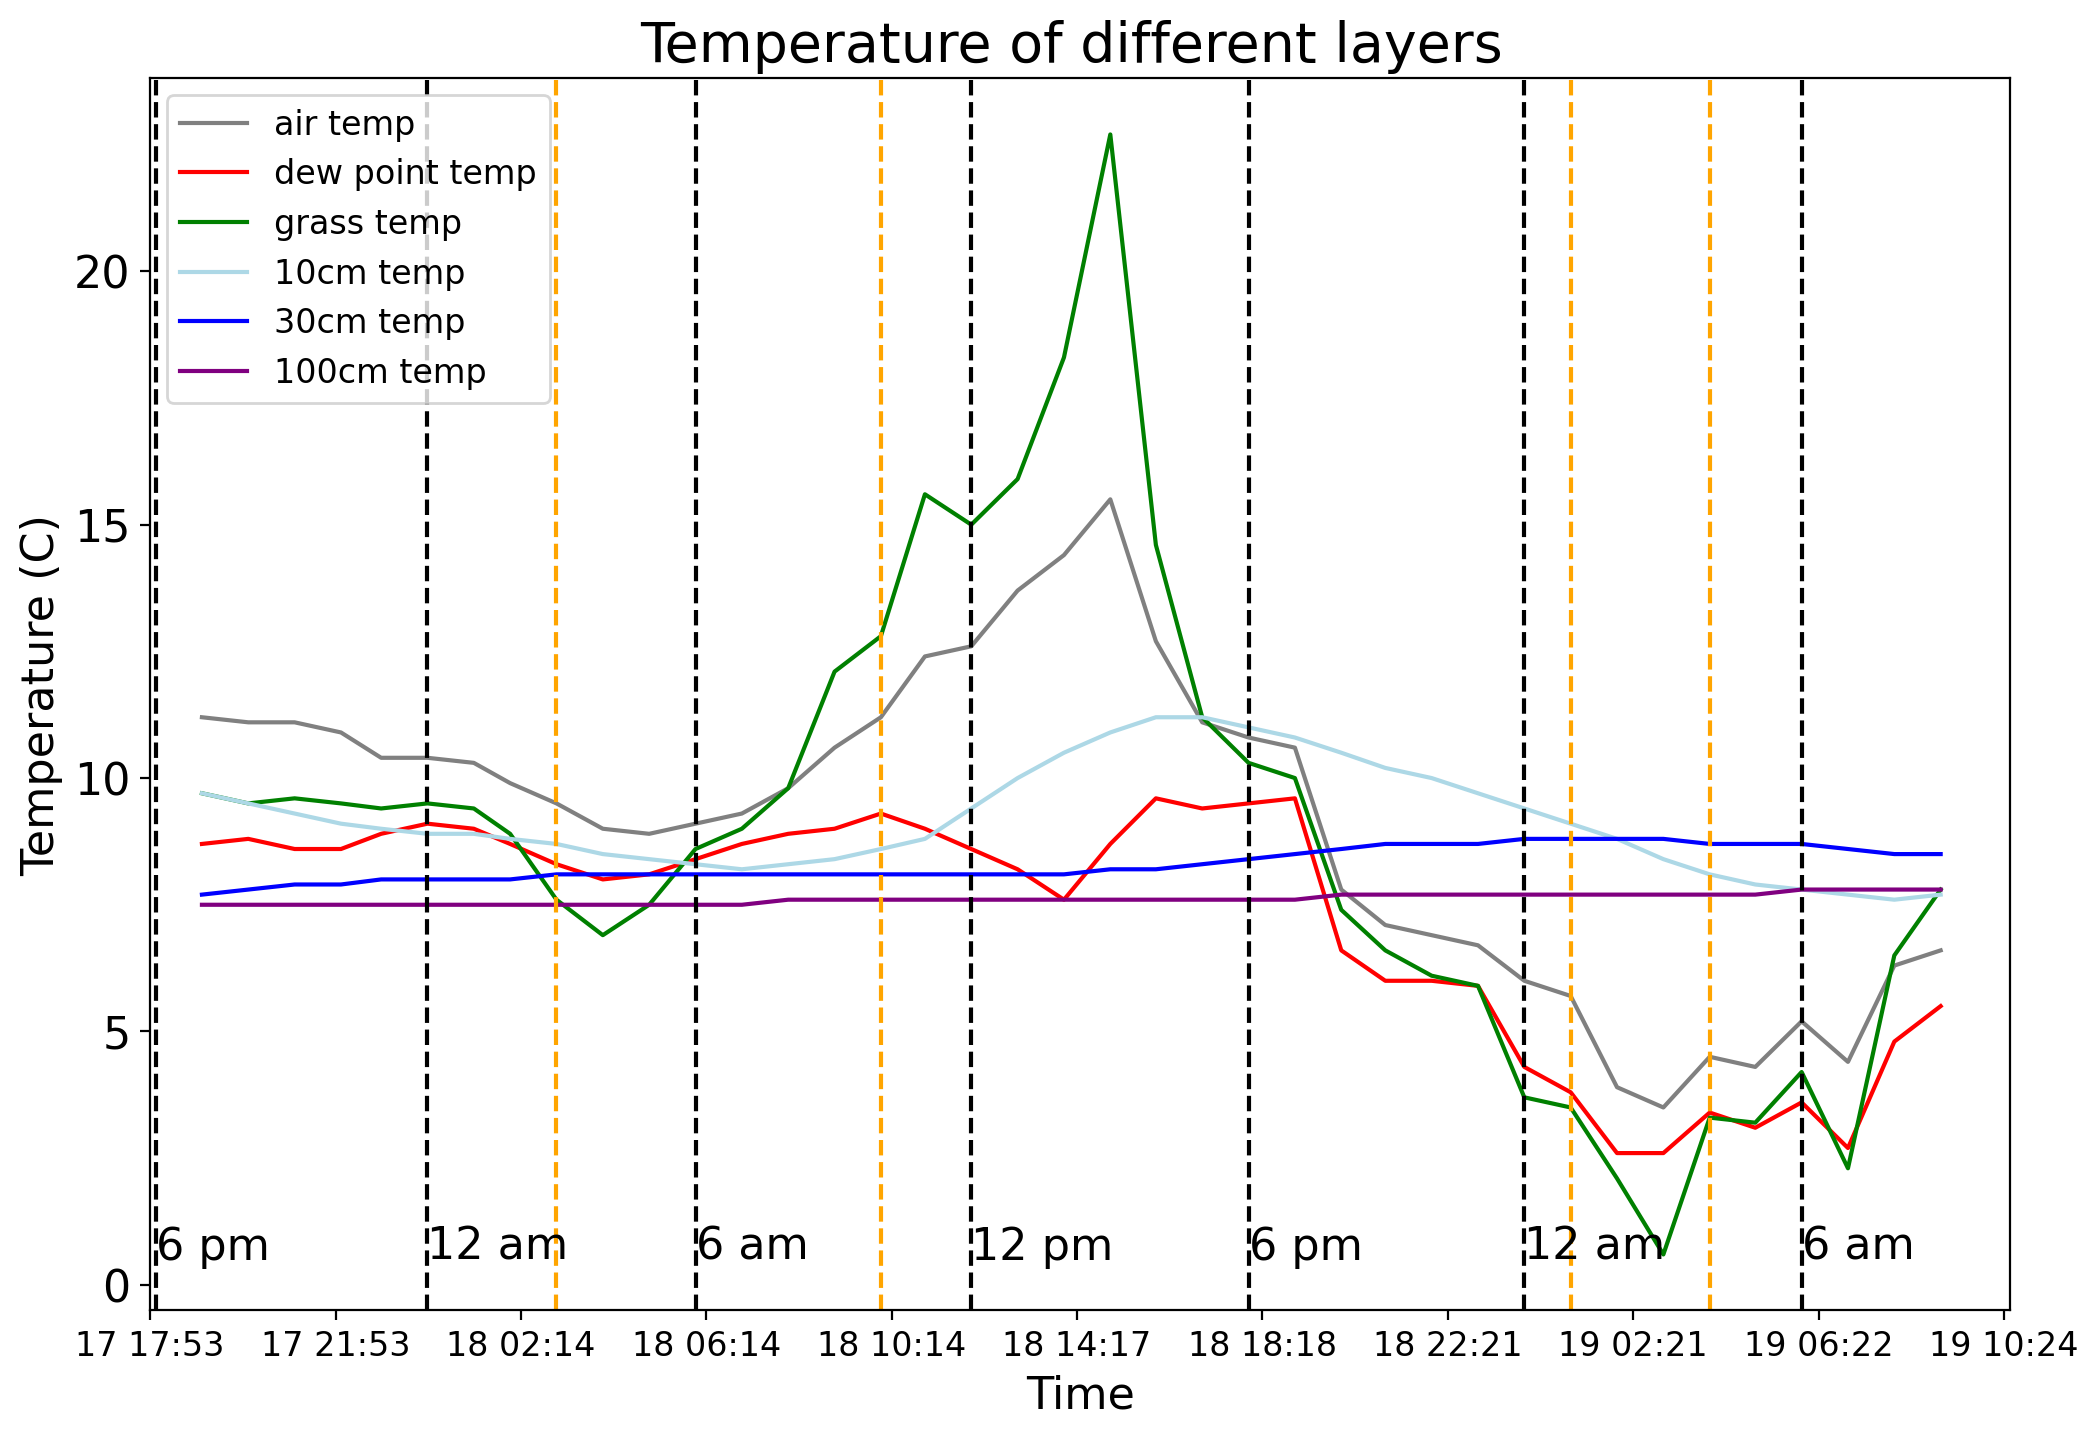

In [11]:
plt.figure(figsize = (12, 8), dpi = 200) 
plt.plot(hourly_index, air_temp, label='air temp', color='gray')
plt.plot(hourly_index, dew_temp, label='dew point temp', color='red')
plt.plot(hourly_index, grs_temp, label='grass temp', color='green')
plt.plot(hourly_index, soil_temp_10, label='10cm temp', color='lightblue')
plt.plot(hourly_index, soil_temp_30, label='30cm temp', color='blue')
plt.plot(hourly_index, soil_temp_100, label='100cm temp', color='purple')
plt.legend(fontsize = 12)
plt.xticks(xax, hrax, fontsize = 12)
plt.xlim(0, ave_psd.shape[-1])
plt.xlabel("Time", fontsize = 16)
plt.ylabel("Temperature (C)", fontsize = 16)
plt.title('Temperature of different layers ', fontsize = 20)  

plt.axvline(x = hourly_index[8], color = 'orange', linestyle='--')
plt.axvline(x = hourly_index[15], color = 'orange', linestyle='--')
plt.axvline(x = hourly_index[30], color = 'orange', linestyle='--')
plt.axvline(x = hourly_index[33], color = 'orange', linestyle='--')


for it in Ind6hrs:
    plt.axvline(x = it, color = 'k', linestyle='--')
plt.text(Ind6hrs[0], 0.5, '6 pm', color='k')
plt.text(Ind6hrs[1], 0.5, '12 am', color='k')
plt.text(Ind6hrs[2], 0.5, '6 am', color='k')
plt.text(Ind6hrs[3], 0.5, '12 pm', color='k')
plt.text(Ind6hrs[4], 0.5, '6 pm', color='k')
plt.text(Ind6hrs[5], 0.5, '12 am', color='k')
plt.text(Ind6hrs[6], 0.5, '6 am', color='k')

# Data --ACF 

### Stretch using mean ACF, and stack for a reference ACF

In [77]:
freqmin=25
freqmax=50
samp_freq = 500
dchan = 3.19
win_st = int(0.012*samp_freq)
stretch_range = np.arange(0.1, 2, 0.01)

In [ ]:
with h5py.File('/fd1/QibinShi_data/England_farm/autocorr_'+str(freqmin)+'_'+str(freqmax)+'Hz.hdf5', 'r') as f:
    corr_all_time = f['autocorr'][:, :, 2500:, 0]
    
x=np.arange(corr_all_time.shape[1])
y=np.arange(corr_all_time.shape[2])
xax=np.arange(0, x.shape[-1], 48)
tax=acqu_time[:2410:240]


time = y[win_st:] / samp_freq
stack_stretch=np.zeros((51, len(time)), dtype = np.float32)

for iloc in range(51):
    data_plot=corr_all_time[iloc].T
    trunc_acf = data_plot[win_st:, :]
    trunc_stk = np.mean(trunc_acf, axis=1)
    
    count = 0
#     plt.figure(figsize = (10, 3), dpi = 200)
    for i in x[::5]:
        tmp=np.zeros_like(time)
        stretched, time_new, ratio, cc = stretch(trunc_stk, trunc_acf[:,i], time, min_ratio=0.1, max_ratio=2)
        if cc > 0.5:  # stack
            length=min(len(stretched), len(time))
            tmp[:length]=stretched[:length]
            stack_stretch[iloc, :] += tmp
#             plt.plot(time, tmp)
            count +=1
        else:continue
#     plt.plot(time, stack_stretch[iloc, :]/count, c='k', lw=9, alpha=0.5, label='mean of all')
#     plt.title('channel '+ str(iloc+44)); plt.legend(); plt.xlabel('lag time (s)')

### Two examples: dvv distribution 

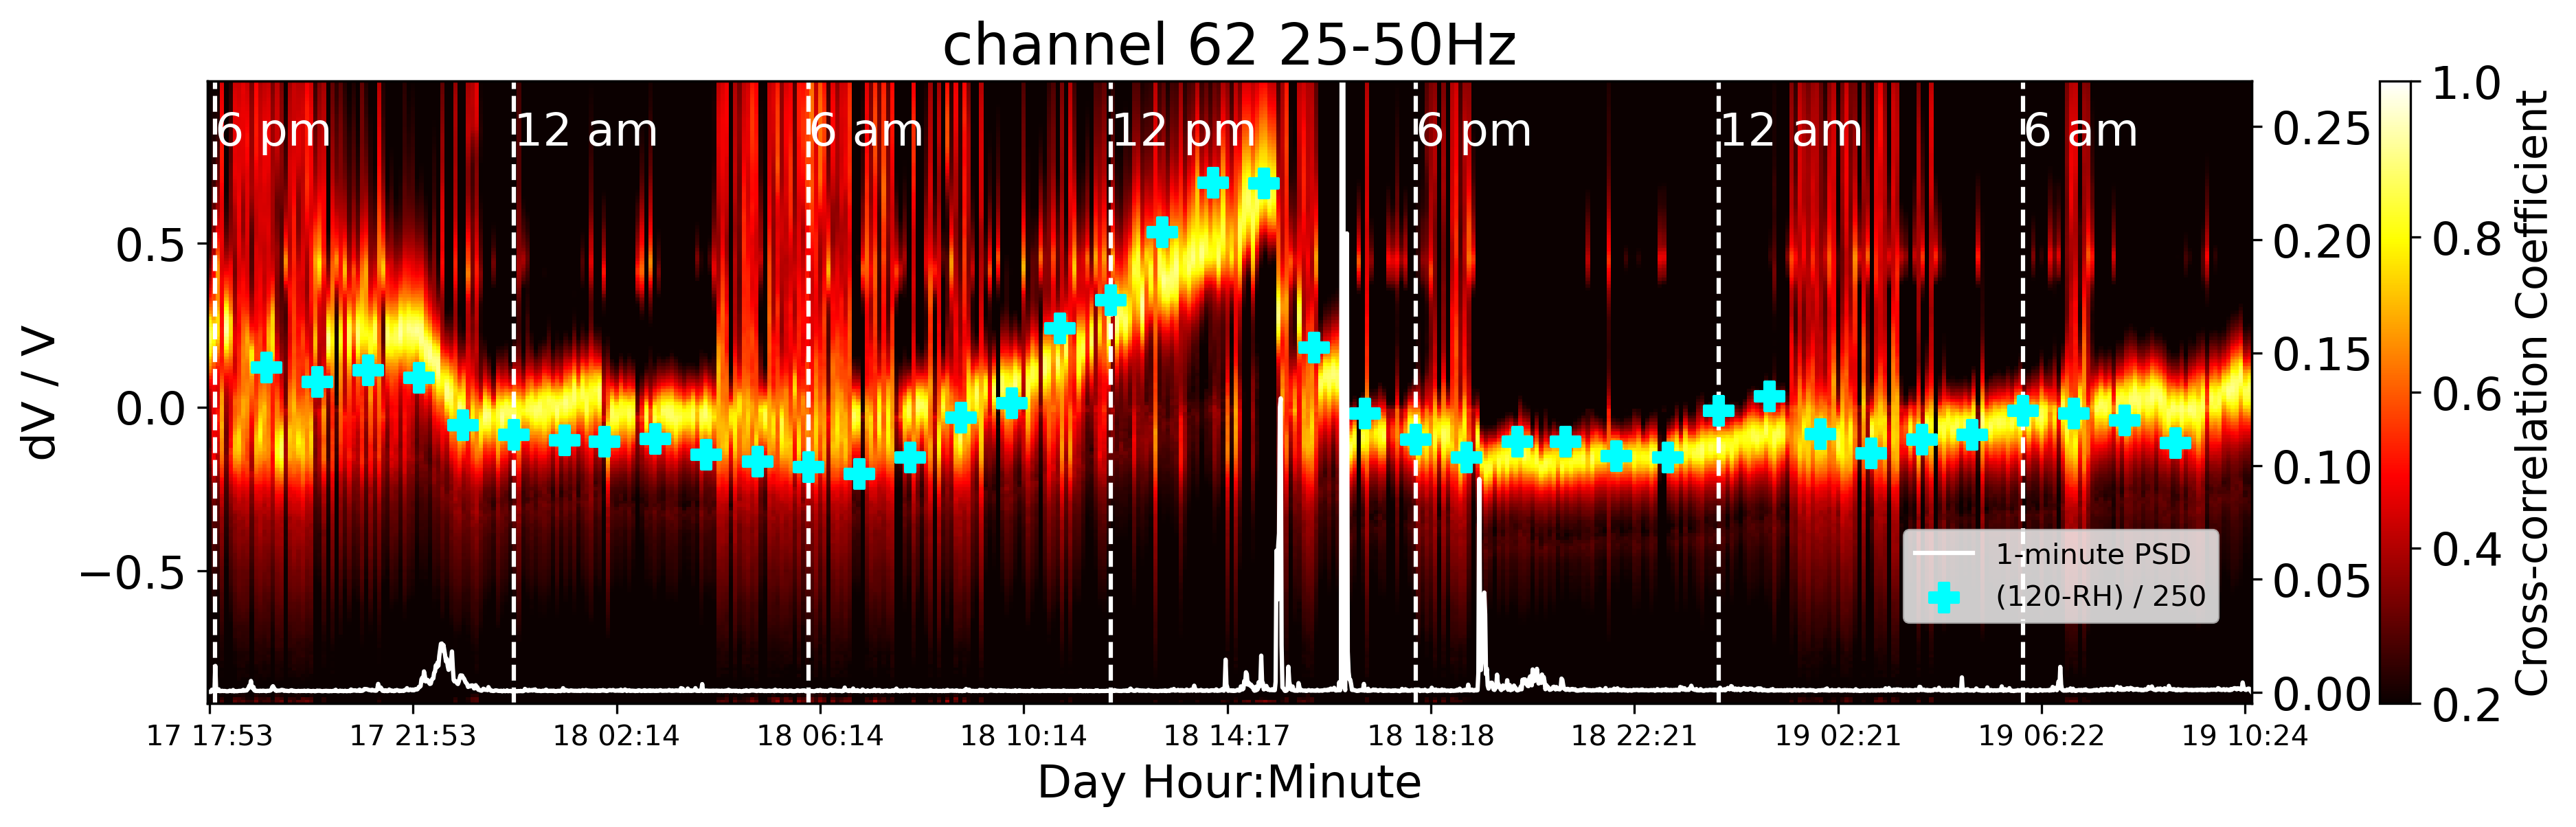

In [13]:
all_cc = np.zeros((51, len(stretch_range), len(x)), dtype = np.float32)

for iloc in [18, 33]:
    data_plot=corr_all_time[iloc].T
    trunc_acf = data_plot[win_st:, :]
    trunc_stk = stack_stretch[iloc, :]/count
    strecthed_acfs = np.zeros_like(trunc_acf)
    for i in x:
        ratios, ccs = stretch_distribution(trunc_stk, trunc_acf[:,i], time, min_ratio=0.1, max_ratio=2)
        all_cc[iloc, :, i] = ccs  
    plt.figure(figsize = (16, 4), dpi = 300)
    plt.pcolormesh(x, stretch_range-1, all_cc[iloc], shading='auto', vmin=0.2, vmax=1, cmap = 'hot')
    plt.xticks(xax, hrax, fontsize = 10)
    plt.xlabel("Day Hour:Minute", fontsize = 16)
    plt.ylabel("dV / V", fontsize = 16)

    plt.title('channel '+ str(iloc+44)+ ' ' + str(freqmin)+'-'+str(freqmax)+'Hz', fontsize = 20)
    bar = plt.colorbar()
    bar.set_label('Cross-correlation Coefficient', fontsize = 15)
    for it in Ind6hrs:
        plt.axvline(x = it/5, color = 'w', linestyle='--')
    plt.text(Ind6hrs[0]/5, 0.8, '6 pm', color='w')
    plt.text(Ind6hrs[1]/5, 0.8, '12 am', color='w')
    plt.text(Ind6hrs[2]/5, 0.8, '6 am', color='w')
    plt.text(Ind6hrs[3]/5, 0.8, '12 pm', color='w')
    plt.text(Ind6hrs[4]/5, 0.8, '6 pm', color='w')
    plt.text(Ind6hrs[5]/5, 0.8, '12 am', color='w')
    plt.text(Ind6hrs[6]/5, 0.8, '6 am', color='w')

    
    axcopy = plt.twinx()
#     axcopy.scatter(np.array(hourly_index)/5, soil_temp_10-7.5, label='T_10cm', color='w', marker='^')
#     axcopy.scatter(np.array(hourly_index)/5, (soil_temp_30-7.5), label='T_30cm', color='w', marker='s')
#     axcopy.scatter(np.array(hourly_index)/5, (soil_temp_100-7.5), label='T_100cm', color='w', marker='v')
    axcopy.scatter(np.array(hourly_index)/5, (120-humidity)/250, label='(120-RH) / 250', color='cyan', marker='P', s=100)
#     axcopy.scatter(np.array(hourly_index)/5, rain_diff/3.5, label='1-hour rainfall', color='g', marker='o', s=100)
#     axcopy.scatter(np.array(hourly_index)/5, np.array(hr_psd), label='1-hour PSD', color='b', marker='*', s=100)
#     axcopy.plot(np.array(hourly_index)/5, np.array(hr_psd))
    axcopy.plot(np.arange(ave_psd.shape[-1])/5, ave_psd, label='1-minute PSD', color='w')
    axcopy.legend(fontsize = 10, loc=(0.83,0.13))
    axcopy.set_ylim(-0.005,0.27)
    plt.savefig('dvv_rain_moisture_ch'+str(iloc)+'.png')

### Enhance dvv -- some channels

In [14]:
# for iloc in [2,6,16,22,30,44]:
for iloc in [20]:
# for iloc in range(51):
    data_plot=corr_all_time[iloc].T
    trunc_acf = data_plot[win_st:, :]
    trunc_stk = stack_stretch[iloc, :]/count
    strecthed_acfs = np.zeros_like(trunc_acf)
    for i in x:
        ratios, ccs = stretch_distribution(trunc_stk, trunc_acf[:,i], time, min_ratio=0.1, max_ratio=2)
        all_cc[iloc, :, i] = ccs 
        
    ######################
    # %% Use cone-filter
    filt_data, filtered_fk, fk2d = fk_filter_2cones(all_cc[iloc].T, w1=0.03, w2=0.005, cone1=True, cone2=False)
    # %% Use median-filter
    image = filt_data.real.T[:,:,np.newaxis]*200
    image = image - np.nanmin(image)
    denoised_image = cv2.medianBlur(image.astype(np.uint8), 7)/256
    #######################
    
    plt.figure(figsize=(18, 5))
    plt.pcolormesh(x, stretch_range-1, denoised_image, shading='auto', vmin=0.3, vmax=0.8, cmap = 'hot')
    plt.title('median filter in 2D_iloc' + str(iloc))
    plt.xticks(xax, hrax, fontsize = 10)
#     bar=plt.colorbar(location='bottom')
#     bar.set_label('Cross-correlation Coefficient', fontsize = 15)
    plt.xlabel("Day Hour:Minute", fontsize = 16)
    plt.ylabel("dV / V", fontsize = 16)
    for it in Ind6hrs:
        plt.axvline(x = it/5, color = 'w', linestyle='--')
    plt.text(Ind6hrs[0]/5, 0.5, '6 pm', color='w')
    plt.text(Ind6hrs[1]/5, 0.5, '12 am', color='w')
    plt.text(Ind6hrs[2]/5, 0.5, '6 am', color='w')
    plt.text(Ind6hrs[3]/5, 0.5, '12 pm', color='w')
    plt.text(Ind6hrs[4]/5, 0.5, '6 pm', color='w')
    plt.text(Ind6hrs[5]/5, 0.5, '12 am', color='w')
    plt.text(Ind6hrs[6]/5, 0.5, '6 am', color='w')

    ######################
    dvv_ind = np.argmax(denoised_image, axis=0)
    dvv = np.zeros(len(dvv_ind), dtype=np.float32)
    for i in range(len(dvv_ind)):
        dvv[i]= stretch_range[dvv_ind[i]]
    cc_dvv = np.nanmax(denoised_image, axis=0)
    ######################

    plt.scatter(x, dvv-1, cmap='viridis', c=cc_dvv, s=10, marker='o')
    plt.xticks(xax, hrax, fontsize = 10)
    plt.title('dVV after denoising')
    plt.xlim(0, x.shape[-1])
    bar=plt.colorbar(location='bottom', aspect=50)
    bar.set_label('Cross-correlation Coefficient', fontsize = 15)

NameError: name 'cv2' is not defined

### Enhance all channels and get reference dvv

In [14]:
# 2D space time of dvv
time = y[win_st:win_st+75] / samp_freq

all_dvv = np.zeros((51, len(x)), dtype = np.float32)
all_cc = np.zeros((51, len(stretch_range), len(x)), dtype = np.float32)

for iloc in range(51):
    data_plot=corr_all_time[iloc].T
    trunc_acf = data_plot[win_st:win_st+75, :]
    trunc_stk = stack_stretch[iloc, :75]/count
    strecthed_acfs = np.zeros_like(trunc_acf)
    for i in x:
        ratios, ccs = stretch_distribution(trunc_stk, trunc_acf[:,i], time, min_ratio=0.1, max_ratio=2)
        all_cc[iloc, :, i] = ccs 
        
    ######################
    ## Denoising
    # %% Use cone-filter
    filt_data, filtered_fk, fk2d = fk_filter_2cones(all_cc[iloc].T, w1=0.03, w2=0.005, cone1=True, cone2=False)
    image = filt_data.real.T[:,:]
    image = image - np.nanmin(image)
    denoised_image = gaussian_filter(image, sigma=1)
    #######################
    dvv_ind = np.argmax(denoised_image, axis=0)
    for i in range(len(dvv_ind)):
        all_dvv[iloc, i]= stretch_range[dvv_ind[i]]
    # cc_dvv = np.nanmax(denoised_image, axis=0)
    ######################


## Method 1 to set bounds for dvv

### Refine dvv bounds using the reference dvv

In [18]:
# Search dvv again using find_peaks and based on the 1st-round dvv  
time = y[win_st:] / samp_freq

new_dvv = np.zeros((51, len(x)), dtype = np.float32)
new_cc = np.zeros((51, len(stretch_range), len(x)), dtype = np.float32)
cc_dvv = np.zeros((51, len(x)), dtype = np.float32)
peaks = np.zeros((51, len(x)), dtype=np.float32)


xax=np.arange(0, x.shape[-1], 48)
tax=acqu_time[:2410:240]

for iloc in range(51):
    data_plot=corr_all_time[iloc].T
    trunc_acf = data_plot[win_st:, :]
    trunc_stk = stack_stretch[iloc, :]/count
    strecthed_acfs = np.zeros_like(trunc_acf)
    for i in x:
        ratios, ccs = stretch_distribution(trunc_stk, trunc_acf[:,i], time, min_ratio=0.1, max_ratio=2)
        new_cc[iloc, :, i] = ccs 
        
    ######################
    ## Denoising
    # %% Use cone-filter
    filt_data, filtered_fk, fk2d = fk_filter_2cones(new_cc[iloc].T, w1=0.03, w2=0.005, cone1=True, cone2=False)
    image = filt_data.real.T[:,:]
    image = image - np.nanmin(image)
    denoised_image = gaussian_filter(image, sigma=2)
    
    #######################
    ## set bounds using 1st round dvv
    upper = int(np.percentile(all_dvv[iloc], 99) / 0.01 + 10)
    lower = int(np.percentile(all_dvv[iloc],  1) / 0.01 - 10)
    dvv_ind = np.argmax(denoised_image[lower:upper, :], axis=0) + lower

    
    for i in range(len(dvv_ind)):
        new_dvv[iloc, i]= stretch_range[dvv_ind[i]]
        peak_ind, _ = find_peaks(denoised_image[lower:upper, i], prominence=0.003, height=0.35)
        if len(peak_ind) > 0:
            peaks[iloc,i] = stretch_range[peak_ind[-1]+lower]
            cc_dvv[iloc,i] = denoised_image[peak_ind[-1]+lower, i]
        else: 
            peaks[iloc,i] = stretch_range[dvv_ind[i]]
            cc_dvv[iloc,i] = denoised_image[dvv_ind[i], i]   

KeyboardInterrupt: 

NFFT=8192 samples, equivalent to 81.92 seconds
saturated for period > 40.96 seconds


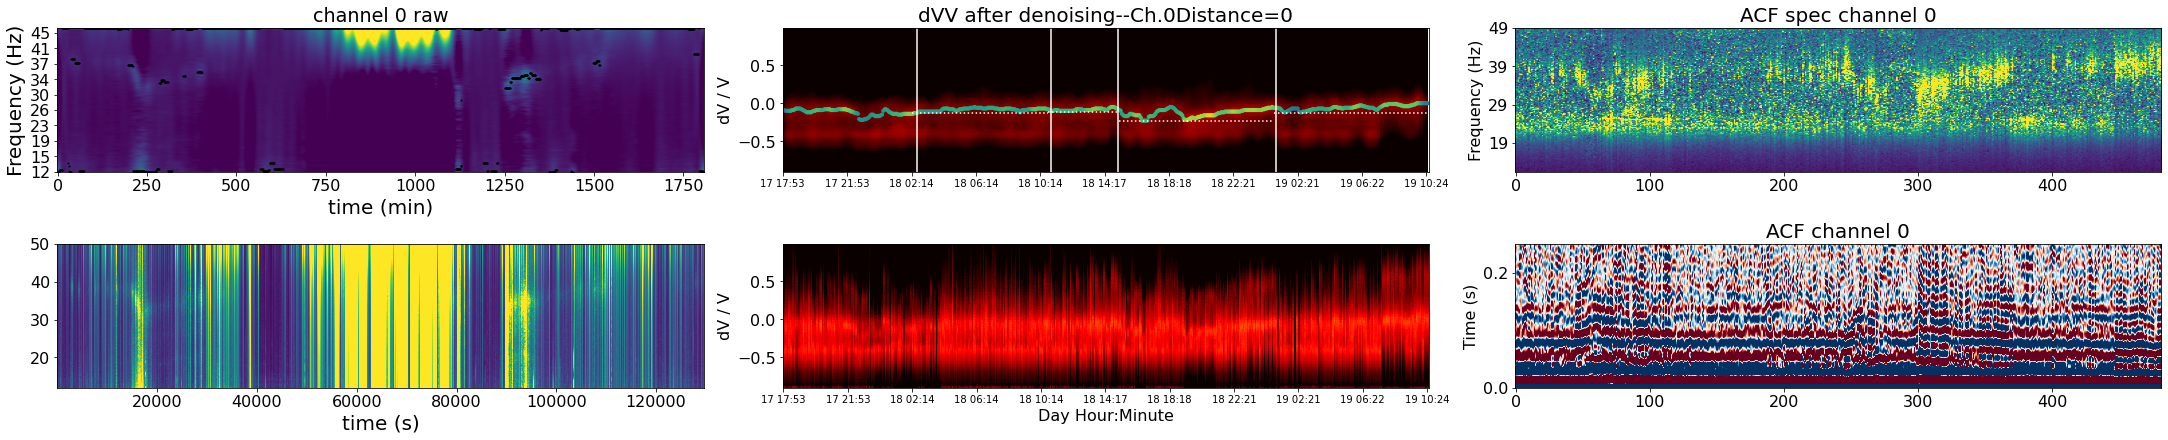

In [41]:
# Search dvv again using find_peaks and based on the 1st-round dvv  
time = y[win_st:] / samp_freq

new_cc = np.zeros((51, len(stretch_range), len(x)), dtype = np.float32)
cc_dvv = np.zeros((51, len(x)), dtype = np.float32)
new_peaks = np.zeros((51, len(x)), dtype=np.float32)


xax=np.arange(0, x.shape[-1], 48)
tax=acqu_time[:2410:240]

nfft, time_width = calc_NFFT(full_time_data[33], sample_rate, power_of_2=True)
print(f'saturated for period > {time_width/2} seconds')

for iloc in np.arange(0,2,2):

    fig, ax = plt.subplots(2, 3, figsize=(30, 6), constrained_layout=True)

    ############################################################################################################ Spectrogram
    # %% calculate the best NFFT for plotting
 
    Pxx, freqs, bins, image = ax[1,0].specgram(full_time_data[iloc], Fs=sample_rate,
                                    mode='magnitude',NFFT=nfft,noverlap=int(nfft/8), 
                                    scale='linear', vmin=0, vmax=0.01)
    ax[1,0].set_xlabel("time (s)", fontsize = 20)
    ax[1,0].set_ylim(12, 50)

    ######################
    ## Denoising
    filtered_image = Pxx[1000:]
    freqs1 = freqs[1000:]

    ##### iterations
    for i in range(4):
        filt_data, filtered_fk, fk2d = fk_filter_2cones(filtered_image.T, w1=0.001*(i+1), w2=0.005, cone1=True, cone2=False)
        image = filt_data.real.T
        image = image - np.nanmin(image)
        filtered_image = scipy.ndimage.gaussian_filter(image, sigma=i+2)

    filtered_image = filtered_image[:-300]
    freqs1 = freqs1[:-300]

    q1=np.percentile(filtered_image, q=25)
    q2=np.percentile(filtered_image, q=99)
    ax[0,0].imshow(filtered_image, aspect='auto', cmap='viridis', origin='lower', vmax=q2, vmin=q1)
    ax[0,0].set_yticks(np.arange(0, 2701, 300))
    ax[0,0].set_yticklabels(freqs1[::300].astype(int))

    Pxx1 = filtered_image
    freq_ind1 = np.argmax(Pxx1, axis=0)

    ax[0,0].scatter(np.arange(1807), freq_ind1, marker='o', s=1, edgecolors='k')
    ax[0,0].set_xlabel("time (min)", fontsize = 20)
    ax[0,0].set_ylabel("Peak-PSD frequency (Hz)", fontsize = 20)
    ax[0,0].set_ylabel("Frequency (Hz)", fontsize = 20)
    ax[0,0].set_title(f'channel {iloc} denoised')
    ax[0,0].set_title(f'channel {iloc} raw')


    ############################################################################################################ stretching for dv


    data_plot=corr_all_time[iloc].T
    trunc_acf = data_plot[win_st:, :]
    trunc_stk = stack_stretch[iloc, :]/count
    strecthed_acfs = np.zeros_like(trunc_acf)
    for i in x:
        ratios, ccs = stretch_distribution(trunc_stk, trunc_acf[:,i], time, min_ratio=0.1, max_ratio=2)
        new_cc[iloc, :, i] = ccs 
        
    ######################
    ## Denoising
    # %% Use cone-filter
    filt_data, filtered_fk, fk2d = fk_filter_2cones(new_cc[iloc].T, w1=0.03, w2=0.005, cone1=True, cone2=False)
    image = filt_data.real.T[:,:]
    image = image - np.nanmin(image)
    # denoised_image = cv2.medianBlur(image.astype(np.uint8), 7)/256
    denoised_image = gaussian_filter(image, sigma=2)
    
    ax[0,1].pcolormesh(x, stretch_range-1, denoised_image, shading='auto', vmin=0.3, vmax=1, cmap='hot')
    ax[0,1].set_xticks(xax)
    ax[0,1].set_xticklabels(hrax, fontsize = 10)
    ######################
        
    dvv_ind = np.zeros(len(x), dtype=np.int32)
    #####################################################################
    jump_point = 1
    for percent in [80,75,70,65,60,55,50,45,40,35,30,25,20,15,10,5]:
        jump = np.percentile(peaks[iloc,0:100], percent) - np.percentile(peaks[iloc,0:100], percent-5)
        if jump > 0.2:
            jump_point = percent
    
    ## set bounds using 1st round dvv
    upper = int(np.percentile(peaks[iloc,0:100], 99) / 0.01 + 5)
    lower = max(int(np.percentile(peaks[iloc,0:100],  jump_point) / 0.01 - 10), 60)
    dvv_ind[0:100] = np.argmax(denoised_image[lower:upper, 0:100], axis=0) + lower
    
    for i in np.arange(0,100):
        peak_ind, _ = find_peaks(denoised_image[lower:upper, i], prominence=0.003, height=0.35)
        if len(peak_ind) > 0:
            new_peaks[iloc,i] = stretch_range[peak_ind[-1]+lower]
            cc_dvv[iloc,i] = denoised_image[peak_ind[-1]+lower, i]
        else: 
            new_peaks[iloc,i] = stretch_range[dvv_ind[i]]
            cc_dvv[iloc,i] = denoised_image[dvv_ind[i], i]   
    
    ax[0,1].hlines(y=stretch_range[lower]-1, color='w', linestyle='dotted', xmin=0, xmax=0.2)
     #####################################################################
    jump_point = 1
    for percent in [80,75,70,65,60,55,50,45,40,35,30,25,20,15,10,5]:
        jump = np.percentile(peaks[iloc,100:200], percent) - np.percentile(peaks[iloc,100:200], percent-5)
        if jump > 0.1:
            jump_point = percent
    
    ## set bounds using 1st round dvv
    upper = int(np.percentile(peaks[iloc,100:200], 99) / 0.01 + 5)
    lower = max(int(np.percentile(peaks[iloc,100:200],  jump_point) / 0.01 - 10), 60)
    dvv_ind[100:200] = np.argmax(denoised_image[lower:upper, 100:200], axis=0) + lower
    
    for i in np.arange(100,200):
        peak_ind, _ = find_peaks(denoised_image[lower:upper, i], prominence=0.003, height=0.35)
        if len(peak_ind) > 0:
            new_peaks[iloc,i] = stretch_range[peak_ind[-1]+lower]
            cc_dvv[iloc,i] = denoised_image[peak_ind[-1]+lower, i]
        else: 
            new_peaks[iloc,i] = stretch_range[dvv_ind[i]]
            cc_dvv[iloc,i] = denoised_image[dvv_ind[i], i]   
            
    ax[0,1].axhline(y=stretch_range[lower]-1, color='w', linestyle='dotted', xmin=0.2, xmax=0.41)
    #####################################################################
    jump_point = 1
    for percent in [80,75,70,65,60,55,50,45,40,35,30,25,20,15,10,5]:
        jump = np.percentile(peaks[iloc,200:250], percent) - np.percentile(peaks[iloc,200:250], percent-5)
        if jump > 0.2:
            jump_point = percent
    
    ## set bounds using 1st round dvv
    upper = int(np.percentile(peaks[iloc,200:250], 99) / 0.01 + 5)
    lower = max(int(np.percentile(peaks[iloc,200:250],  jump_point) / 0.01 - 10), 60)
    dvv_ind[200:250] = np.argmax(denoised_image[lower:upper, 200:250], axis=0) + lower
    
    for i in np.arange(200,250):
        peak_ind, _ = find_peaks(denoised_image[lower:upper, i], prominence=0.003, height=0.35)
        if len(peak_ind) > 0:
            new_peaks[iloc,i] = stretch_range[peak_ind[-1]+lower]
            cc_dvv[iloc,i] = denoised_image[peak_ind[-1]+lower, i]
        else: 
            new_peaks[iloc,i] = stretch_range[dvv_ind[i]]
            cc_dvv[iloc,i] = denoised_image[dvv_ind[i], i]   
            
    ax[0,1].axhline(y=stretch_range[lower]-1, color='w', linestyle='dotted', xmin=0.41, xmax=0.52)
     #####################################################################
    jump_point = 1
    for percent in [80,75,70,65,60,55,50,45,40,35,30,25,20,15,10,5]:
        jump = np.percentile(peaks[iloc,250:368], percent) - np.percentile(peaks[iloc,250:368], percent-5)
        if jump > 0.15:
            jump_point = percent
    
    ## set bounds using 1st round dvv
    upper = int(np.percentile(peaks[iloc,250:368], 99) / 0.01)
    lower = max(int(np.percentile(peaks[iloc,250:368],  jump_point) / 0.01 - 10), 60)
    dvv_ind[250:368] = np.argmax(denoised_image[lower:upper, 250:368], axis=0) + lower
    
    for i in np.arange(250,368):
        peak_ind, _ = find_peaks(denoised_image[lower:upper, i], prominence=0.003, height=0.35)
        if len(peak_ind) > 0:
            new_peaks[iloc,i] = stretch_range[peak_ind[-1]+lower]
            cc_dvv[iloc,i] = denoised_image[peak_ind[-1]+lower, i]
        else: 
            new_peaks[iloc,i] = stretch_range[dvv_ind[i]]
            cc_dvv[iloc,i] = denoised_image[dvv_ind[i], i]   
            
    ax[0,1].axhline(y=stretch_range[lower]-1, color='w', linestyle='dotted', xmin=0.52, xmax=0.76)
     #####################################################################
    jump_point = 1
    for percent in [80,75,70,65,60,55,50,45,40,35,30,25,20,15,10,5]:
        jump = np.percentile(peaks[iloc,368:], percent) - np.percentile(peaks[iloc,368:], percent-5)
        if jump > 0.2:
            jump_point = percent
    
    ## set bounds using 1st round dvv
    upper = int(np.percentile(peaks[iloc,368:], 99) / 0.01 + 5)
    lower = max(int(np.percentile(peaks[iloc,368:],  jump_point) / 0.01 - 10), 60)
    dvv_ind[368:] = np.argmax(denoised_image[lower:upper, 368:], axis=0) + lower
    
    for i in np.arange(368,len(x)):
        peak_ind, _ = find_peaks(denoised_image[lower:upper, i], prominence=0.003, height=0.35)
        if len(peak_ind) > 0:
            new_peaks[iloc,i] = stretch_range[peak_ind[-1]+lower]
            cc_dvv[iloc,i] = denoised_image[peak_ind[-1]+lower, i]
        else: 
            new_peaks[iloc,i] = stretch_range[dvv_ind[i]]
            cc_dvv[iloc,i] = denoised_image[dvv_ind[i], i]   
            
    ax[0,1].axhline(y=stretch_range[lower]-1, color='w', linestyle='dotted', xmin=0.76)
    #####################################################################
    
    
    
    #######################
    ax[0,1].scatter(x, new_peaks[iloc]-1, cmap='viridis', c=cc_dvv[iloc], s=10, marker='o', vmin=0.3, vmax=0.5)
    ax[0,1].set_xticks(xax)
    ax[0,1].set_xticklabels(hrax, fontsize = 10)
    ax[0,1].set_title('dVV after denoising--Ch.'+str(iloc)+'Distance='+str(int(iloc*dchan)), fontsize=20)
    ax[0,1].set_xlim(0, x.shape[-1])
    ax[0,1].set_ylabel("dV / V", fontsize = 16)
    
    ax[0,1].axvline(x = 100, color = 'w', linestyle='-')
    ax[0,1].axvline(x = 200, color = 'w', linestyle='-')
    ax[0,1].axvline(x = 250, color = 'w', linestyle='-')
    ax[0,1].axvline(x = 368, color = 'w', linestyle='-')


        
    ### Raw image of dvv likelihood
    ax[1,1].pcolormesh(x, stretch_range-1, new_cc[iloc], shading='auto', vmin=0.3, vmax=1.0, cmap = 'hot')
    ax[1,1].set_xticks(xax)
    ax[1,1].set_xticklabels(hrax, fontsize = 10)
    ax[1,1].set_xlabel("Day Hour:Minute", fontsize = 16)
    ax[1,1].set_ylabel("dV / V", fontsize = 16)



    ############################################################################################################
    time_steps = data_plot.shape[0]

    # Compute FFT along the time dimension
    fft_data = np.fft.fft(data_plot, axis=0)  # FFT along time
    frequencies = np.fft.fftfreq(time_steps, d=1/samp_freq)   # Frequency axis

    # Take magnitude (or power)
    magnitude_spectrum = np.abs(fft_data)

    # Keep only the positive frequencies (FFT is symmetric)
    half_idx = time_steps // 2
    magnitude_spectrum = magnitude_spectrum[:half_idx, :]
    frequencies = frequencies[:half_idx]
    q1 = np.percentile(magnitude_spectrum, q=25)
    q2 = np.percentile(magnitude_spectrum, q=99)
    q3 = np.percentile(np.abs(data_plot), q=90)

    ax[1,2].imshow(data_plot, aspect='auto', cmap='RdBu', origin='lower', vmin=-q3, vmax=q3)
    ax[1,2].set_yticks(np.arange(0, time_steps, 100))
    ax[1,2].set_yticklabels(np.arange(0, time_steps, 100)/samp_freq)
    ax[1,2].set_ylim(0, time_steps/20)
    ax[1,2].set_title('ACF channel '+ str(iloc), fontsize = 20)
    ax[1,2].set_ylabel("Time (s)", fontsize = 16)
    ax[0,2].imshow(magnitude_spectrum, aspect='auto', cmap='viridis', origin='lower', vmin=q1, vmax=q2)
    ax[0,2].set_yticks(np.arange(0, half_idx, 50))
    ax[0,2].set_yticklabels(frequencies[::50].astype(int))
    ax[0,2].set_ylim(half_idx/20, half_idx/5)
    ax[0,2].set_ylabel("Frequency (Hz)", fontsize = 16)
    ax[0,2].set_title('ACF spec channel '+ str(iloc), fontsize = 20)


In [15]:
corr_all_time.shape

(51, 482, 2501)

## Method 2: enhance dvv by correlating with ACF spectra

(190, 482) (250, 482)
(190, 482) (250, 482)
(190, 482) (250, 482)
(190, 482) (250, 482)
(190, 482) (250, 482)
(190, 482) (250, 482)
(190, 482) (250, 482)
(190, 482) (250, 482)


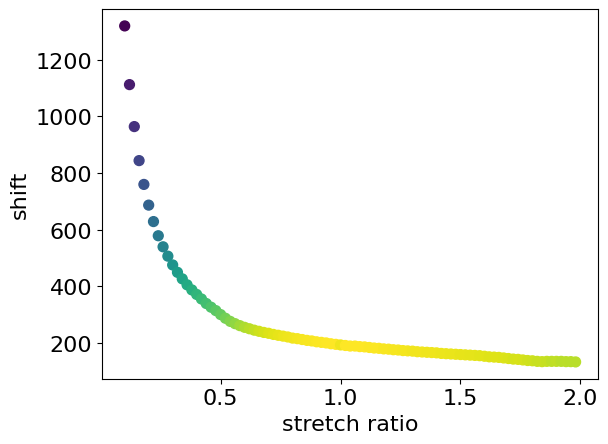

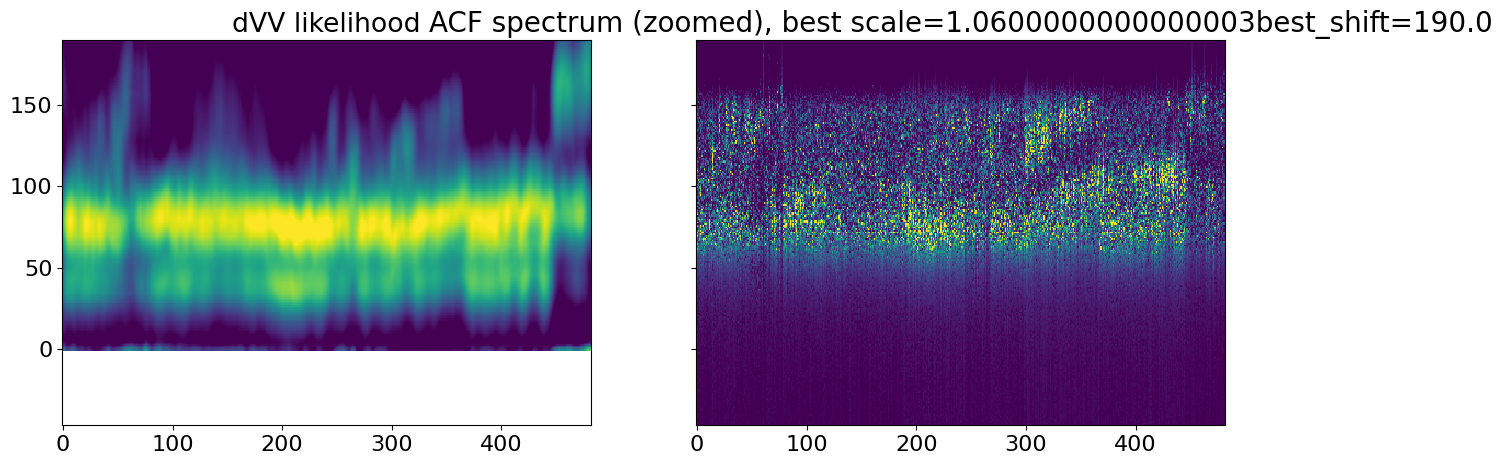

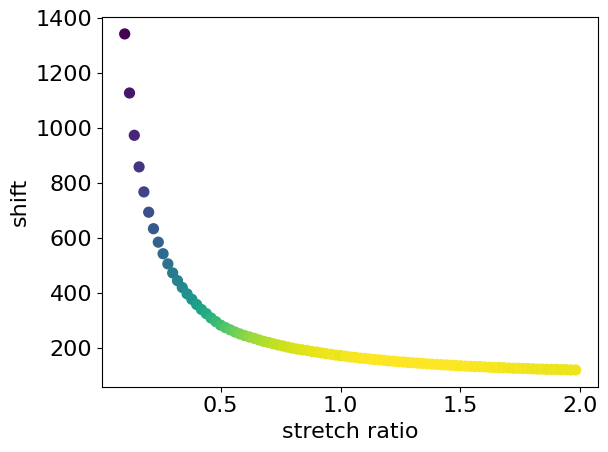

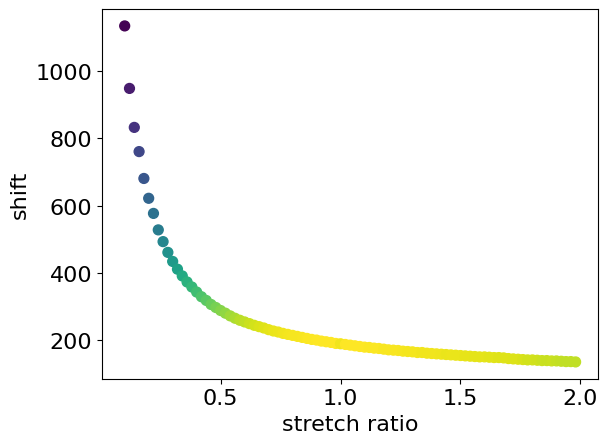

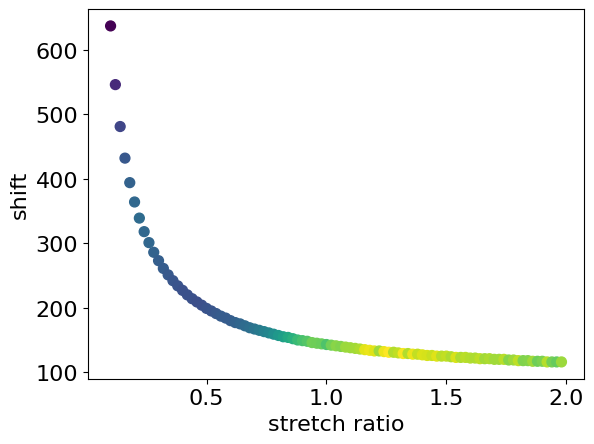

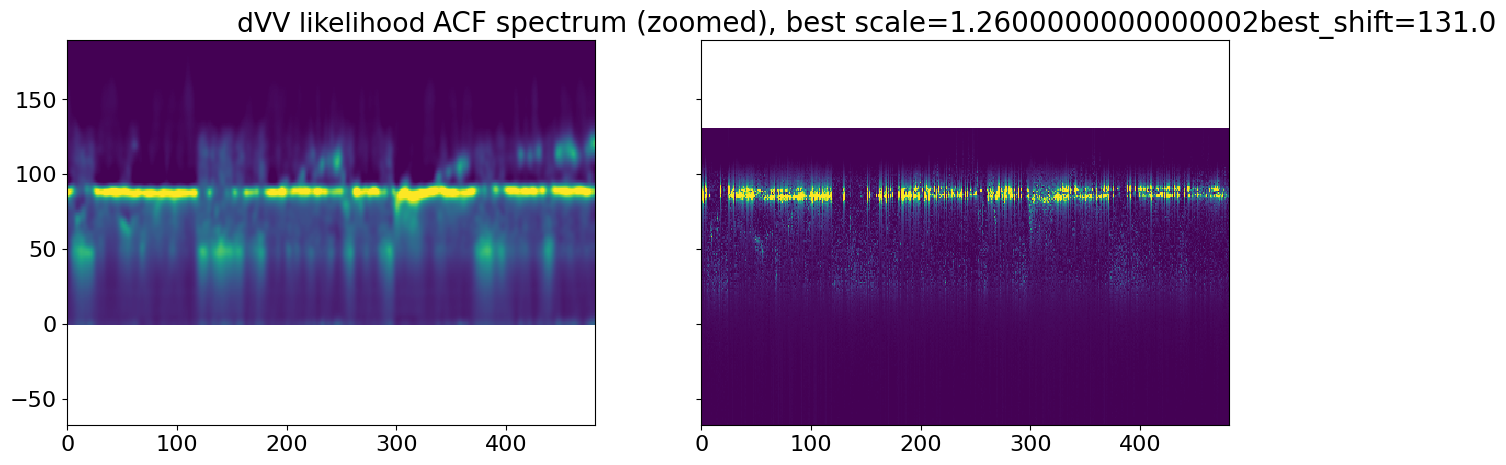

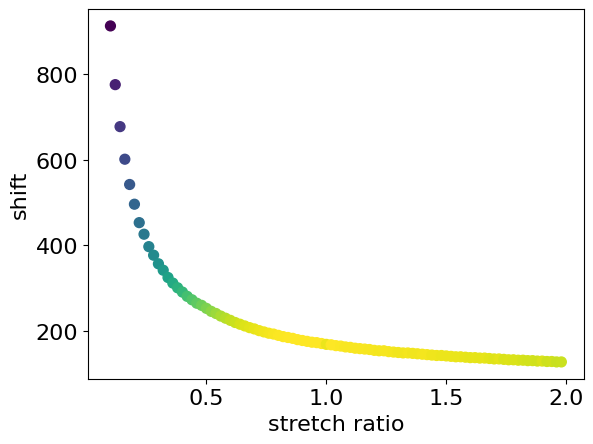

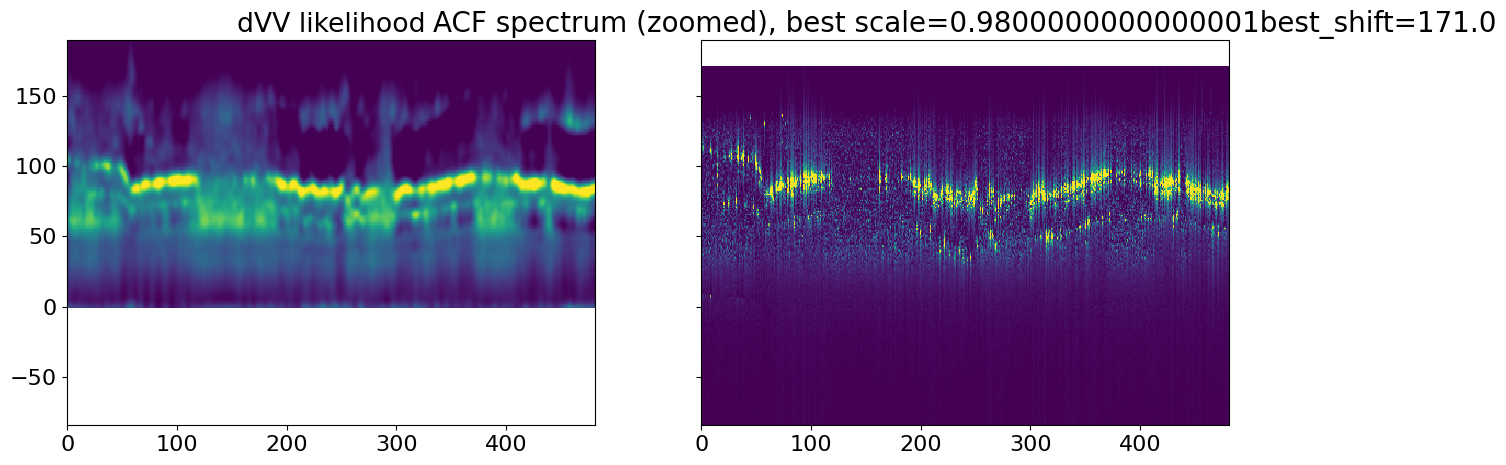

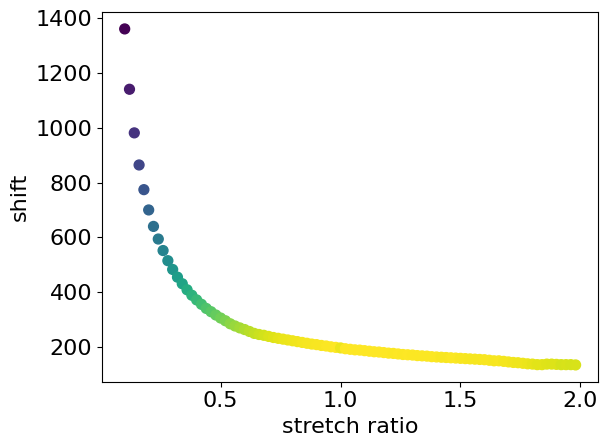

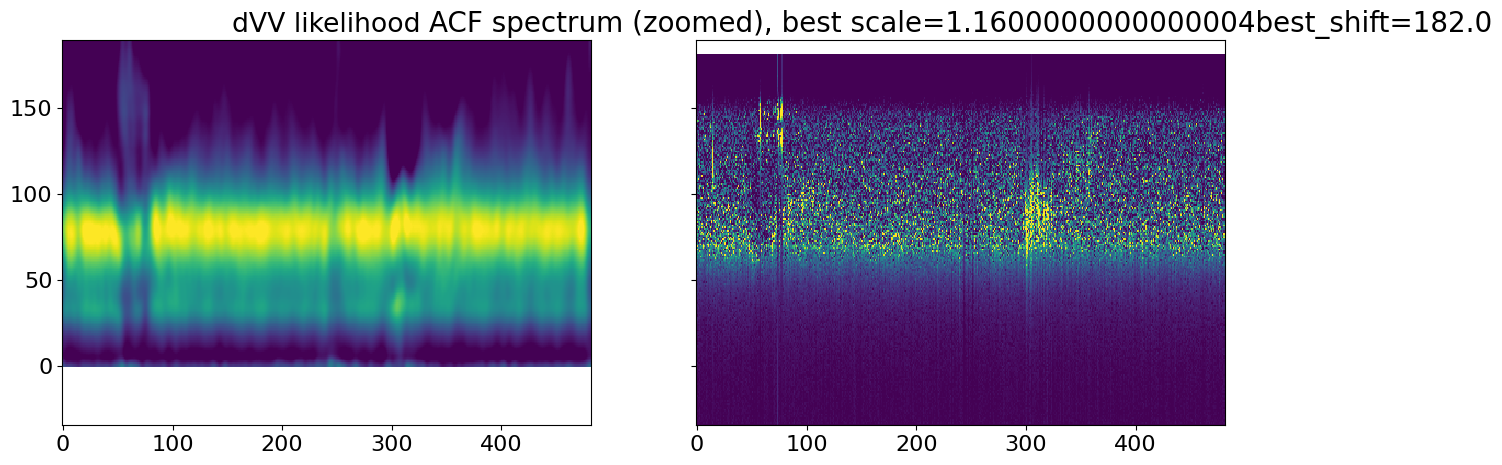

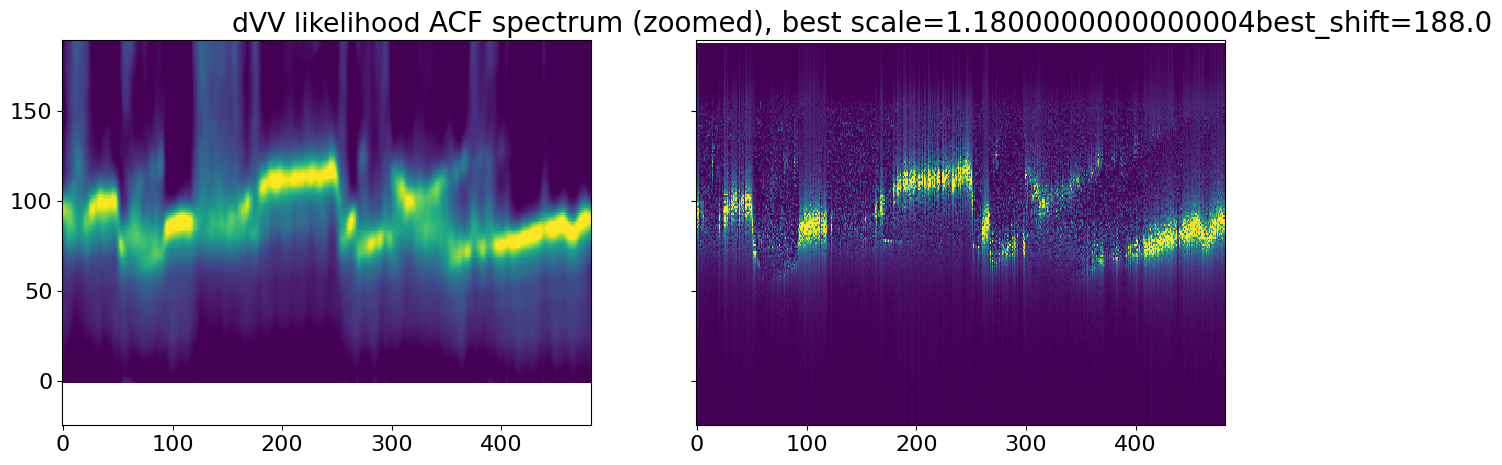

In [83]:
time = y[win_st:] / samp_freq
new_cc = np.zeros((51, len(stretch_range), len(x)), dtype = np.float32)

for iloc in np.arange(2,50,6):

    ######################  Prepare dvv likelihood
    ## slice ACF for a channel, roughly a plot
    data_plot=corr_all_time[iloc].T  # shape (corr lag time, time window number)
    trunc_acf = data_plot[win_st:, :]  # cut out primary phase for stretching
    trunc_stk = stack_stretch[iloc, :] / count  # Reference stack ACF
    
    ## get dvv likelihood for every time window
    for i in x:
        ratios, ccs = stretch_distribution(trunc_stk, trunc_acf[:,i], time, min_ratio=0.1, max_ratio=2)
        new_cc[iloc, :, i] = ccs 
        
    ## Denoise dvv likelihood using FK and Gaussian filter
    filt_data, filtered_fk, fk2d = fk_filter_2cones(new_cc[iloc].T, w1=0.03, w2=0.005, cone1=True, cone2=False)
    image = filt_data.real.T[:,:]  # only real part
    dvv_image = gaussian_filter((image - np.nanmin(image)), sigma=2)


    ######################  Prepare ACF spectra
    decimate_data = scipy.signal.decimate(data_plot, 5, axis=0)
    time_steps = decimate_data.shape[0]
    half_idx = time_steps // 2  # FFT is symmetric

    # Compute FFT along the time dimension
    fft_data = np.fft.fft(decimate_data, axis=0)  # FFT along time
    frequencies = np.fft.fftfreq(time_steps, d=5/samp_freq)
    # Take magnitude and frequency for positive part
    acf_spec = np.abs(fft_data)[:half_idx, :]
    frequencies = frequencies[:half_idx]

    acf_spec = gaussian_filter((acf_spec - np.nanmin(acf_spec)), sigma=2)

    print(dvv_image.shape, acf_spec.shape)


    ############################################################################################################
    compress_range = np.arange(0.1, 2, 0.02)
    strecth_corr = np.zeros((len(compress_range), 2), dtype=np.float32)

    for i, scale in enumerate(compress_range):
        zoom_spec = scipy.ndimage.zoom(acf_spec, (1.0/scale, 1))
        correlate_result = np.zeros((dvv_image.shape[0]+zoom_spec.shape[0]-1, dvv_image.shape[1]), dtype=np.float32)

        for c in range(dvv_image.shape[1]):
            n1 = np.sum(np.square(dvv_image[:,c]))
            n2 = np.sum(np.square(zoom_spec[:,c]))
            correlate_result[:, c] = sgn.correlate(dvv_image[:,c], zoom_spec[:,c]) / np.sqrt(n1 * n2)
            
        strecth_corr[i, 0] = np.argmax(np.mean(correlate_result, axis=1))
        strecth_corr[i, 1] = np.nanmax(np.mean(correlate_result, axis=1))

    best_scale = compress_range[np.argmax(strecth_corr[:,1])]
    best_shift = strecth_corr[np.argmax(strecth_corr[:,1]), 0]

    zoom_spec_best = scipy.ndimage.zoom(acf_spec, (1.0/best_scale, 1))
    bottom_img = zoom_spec_best.shape[0] - best_shift
        
    plt.figure()
    plt.scatter(compress_range, strecth_corr[:,0], marker='o', c=(strecth_corr[:,1]-0.)*100, s=50, cmap='viridis')
    plt.xlabel('stretch ratio')
    plt.ylabel('shift')

    fig, ax = plt.subplots(1,2, figsize=(15, 5), sharey=True)

    q1=np.percentile(dvv_image, q=25)
    q2=np.percentile(dvv_image, q=99)
    ax[0].pcolor(np.arange(482), np.arange(dvv_image.shape[0]), dvv_image, cmap='viridis', vmin=q1, vmax=q2)
    # ax[0].set_ylim(0, dvv_image.shape[0])
    ax[0].set_title('dVV likelihood')

    q1=np.percentile(zoom_spec_best, q=25)
    q2=np.percentile(zoom_spec_best, q=99)
    ax[1].pcolor(np.arange(482), np.arange(zoom_spec_best.shape[0])-bottom_img, zoom_spec_best, cmap='viridis', vmin=q1, vmax=q2)
    ax[1].set_title('ACF spectrum (zoomed), best scale='+str(best_scale) + 'best_shift='+str(best_shift), fontsize=20)



In [82]:
fft_data.shape

(501, 482)

(1880, 482)
(1567, 482)
(1343, 482)
(1175, 482)
(1044, 482)
(940, 482)
(855, 482)
(783, 482)
(723, 482)
(671, 482)
(627, 482)
(587, 482)
(553, 482)
(522, 482)
(495, 482)
(470, 482)
(448, 482)
(427, 482)
(409, 482)
(392, 482)
(376, 482)
(362, 482)
(348, 482)
(336, 482)
(324, 482)
(313, 482)
(303, 482)
(294, 482)
(285, 482)
(276, 482)
(269, 482)
(261, 482)
(254, 482)
(247, 482)
(241, 482)
(235, 482)
(229, 482)
(224, 482)
(219, 482)
(214, 482)
(209, 482)
(204, 482)
(200, 482)
(196, 482)
(192, 482)
(188, 482)
(184, 482)
(181, 482)
(177, 482)
(174, 482)
(171, 482)
(168, 482)
(165, 482)
(162, 482)
(159, 482)
(157, 482)
(154, 482)
(152, 482)
(149, 482)
(147, 482)
(145, 482)
(142, 482)
(140, 482)
(138, 482)
(136, 482)
(134, 482)
(132, 482)
(131, 482)
(129, 482)
(127, 482)
(125, 482)
(124, 482)
(122, 482)
(121, 482)
(119, 482)
(117, 482)
(116, 482)
(115, 482)
(113, 482)
(112, 482)
(111, 482)
(109, 482)
(108, 482)
(107, 482)
(106, 482)
(104, 482)
(103, 482)
(102, 482)
(101, 482)
(100, 482)
(99, 

Text(0.5, 1.0, 'ACF spectrum (zoomed)')

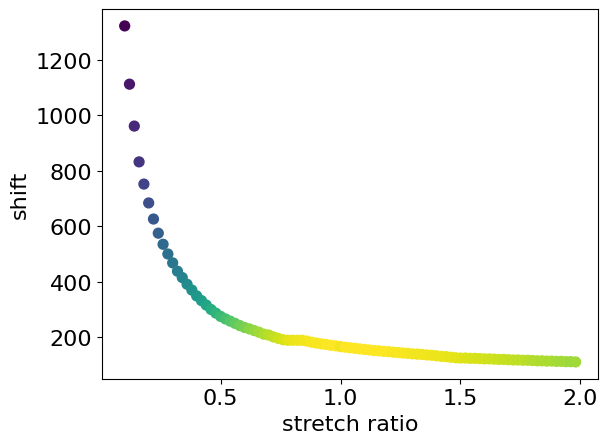

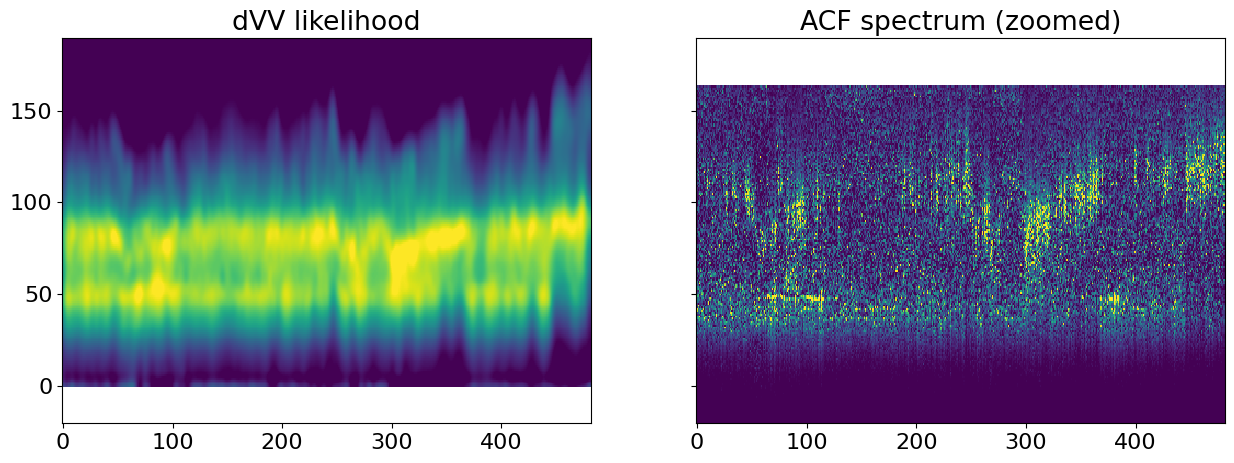

In [74]:

import scipy.ndimage

stretch_range = np.arange(0.1, 2, 0.02)
strecth_corr = np.zeros((len(stretch_range), 2), dtype=np.float32)

for i, scale in enumerate(stretch_range):
    zoom_spec = scipy.ndimage.zoom(acf_spec, (1.0/scale, 1))
    print(zoom_spec.shape)
    correlate_result = np.zeros((dvv_image.shape[0]+zoom_spec.shape[0]-1, dvv_image.shape[1]), dtype=np.float32)

    for c in range(dvv_image.shape[1]):
        n1 = np.sum(np.square(dvv_image[:,c]))
        n2 = np.sum(np.square(zoom_spec[:,c]))
        correlate_result[:, c] = sgn.correlate(dvv_image[:,c], zoom_spec[:,c]) / np.sqrt(n1 * n2)
        
    strecth_corr[i, 0] = np.argmax(np.mean(correlate_result, axis=1))
    strecth_corr[i, 1] = np.nanmax(np.mean(correlate_result, axis=1))

best_scale = stretch_range[np.argmax(strecth_corr[:,1])]
best_shift = strecth_corr[np.argmax(strecth_corr[:,1]), 0]

zoom_spec_best = scipy.ndimage.zoom(acf_spec, (1.0/best_scale, 1))
bottom_img = zoom_spec_best.shape[0] - best_shift
print(best_scale, best_shift, zoom_spec_best.shape[0])
    
plt.figure()
plt.scatter(stretch_range, strecth_corr[:,0], marker='o', c=(strecth_corr[:,1]-0.)*100, s=50, cmap='viridis')
plt.xlabel('stretch ratio')
plt.ylabel('shift')

fig, ax = plt.subplots(1,2, figsize=(15, 5), sharey=True)

q1=np.percentile(dvv_image, q=25)
q2=np.percentile(dvv_image, q=99)
ax[0].pcolor(np.arange(482), np.arange(dvv_image.shape[0]), dvv_image, cmap='viridis', vmin=q1, vmax=q2)
# ax[0].set_ylim(0, dvv_image.shape[0])
ax[0].set_title('dVV likelihood')

q1=np.percentile(zoom_spec_best, q=25)
q2=np.percentile(zoom_spec_best, q=99)
ax[1].pcolor(np.arange(482), np.arange(zoom_spec_best.shape[0])-bottom_img, zoom_spec_best, cmap='viridis', vmin=q1, vmax=q2)
ax[1].set_title('ACF spectrum (zoomed)')


### Plot dvv in space

(-0.02, 0.2)

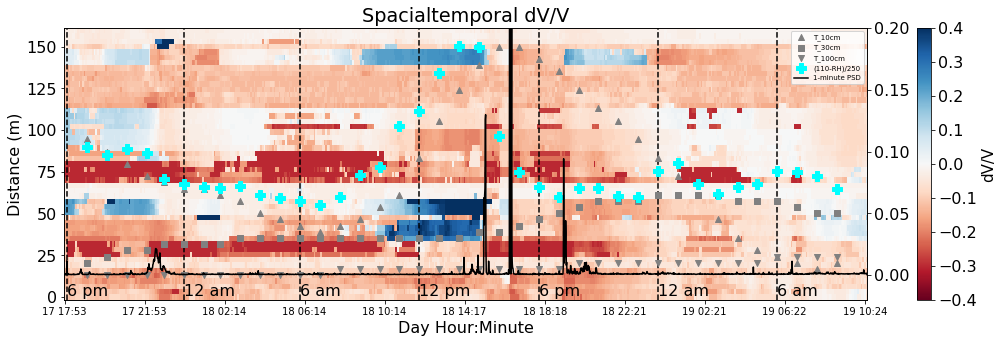

In [14]:
xax=np.arange(0, x.shape[-1], 48)
tax=acqu_time[:2410:240]
plt.figure(figsize=(18, 5))
plt.pcolormesh(x, np.arange(51)*dchan, new_peaks-1, shading='auto', vmin=-0.4, vmax=0.4, cmap = 'RdBu')
plt.title('Spacialtemporal dV/V')
plt.xticks(xax, hrax, fontsize = 10)
bar=plt.colorbar()
bar.set_label('dV/V', fontsize = 15)
plt.xlabel("Day Hour:Minute", fontsize = 16)
plt.ylabel("Distance (m)", fontsize = 16)

for it in Ind6hrs:
    plt.axvline(x = it/5, color = 'k', linestyle='--')
plt.text(Ind6hrs[0]/5, 0.5, '6 pm', color='k')
plt.text(Ind6hrs[1]/5, 0.5, '12 am', color='k')
plt.text(Ind6hrs[2]/5, 0.5, '6 am', color='k')
plt.text(Ind6hrs[3]/5, 0.5, '12 pm', color='k')
plt.text(Ind6hrs[4]/5, 0.5, '6 pm', color='k')
plt.text(Ind6hrs[5]/5, 0.5, '12 am', color='k')
plt.text(Ind6hrs[6]/5, 0.5, '6 am', color='k')

axcopy = plt.twinx()
axcopy.scatter(np.array(hourly_index)/5, (soil_temp_10-7.5)/20, label='T_10cm', color='gray', marker='^')
axcopy.scatter(np.array(hourly_index)/5, (soil_temp_30-7.5)/20, label='T_30cm', color='gray', marker='s')
axcopy.scatter(np.array(hourly_index)/5, (soil_temp_100-7.5)/20, label='T_100cm', color='gray', marker='v')
axcopy.scatter(np.array(hourly_index)/5, (110-humidity)/250, label='(110-RH)/250', color='cyan', marker='P', s=100)
axcopy.plot(np.arange(ave_psd.shape[-1])/5, ave_psd, label='1-minute PSD', color='k')
axcopy.legend(fontsize = 7)
axcopy.set_ylim(-0.02,0.2)

In [15]:
ave=np.repeat(np.mean(new_peaks[:,-10:], axis=1)[:, np.newaxis], 482, axis=1)
amp = new_peaks-ave

Text(427.6, 0.5, '6 am')

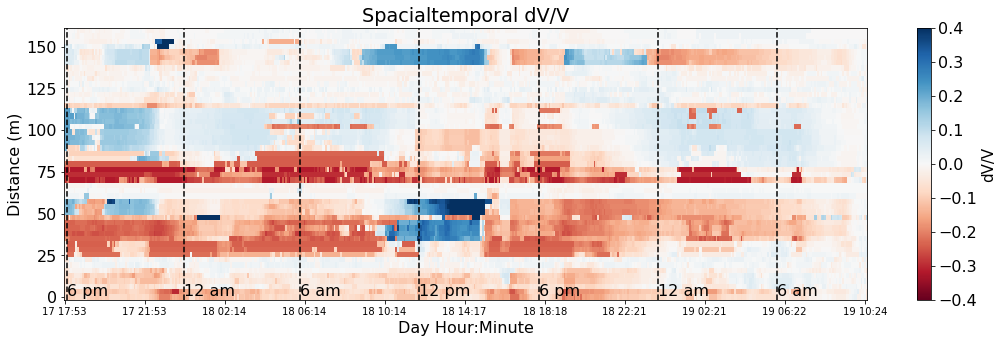

In [16]:
plt.figure(figsize=(18, 5))
plt.pcolormesh(x, np.arange(51)*dchan, amp, shading='auto', vmin=-0.4, vmax=0.4, cmap = 'RdBu')
plt.title('Spacialtemporal dV/V')
plt.xticks(xax, hrax, fontsize = 10)
bar=plt.colorbar()
bar.set_label('dV/V', fontsize = 15)
plt.xlabel("Day Hour:Minute", fontsize = 16)
plt.ylabel("Distance (m)", fontsize = 16)

for it in Ind6hrs:
    plt.axvline(x = it/5, color = 'k', linestyle='--')
plt.text(Ind6hrs[0]/5, 0.5, '6 pm', color='k')
plt.text(Ind6hrs[1]/5, 0.5, '12 am', color='k')
plt.text(Ind6hrs[2]/5, 0.5, '6 am', color='k')
plt.text(Ind6hrs[3]/5, 0.5, '12 pm', color='k')
plt.text(Ind6hrs[4]/5, 0.5, '6 pm', color='k')
plt.text(Ind6hrs[5]/5, 0.5, '12 am', color='k')
plt.text(Ind6hrs[6]/5, 0.5, '6 am', color='k')

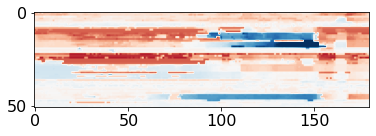

In [ ]:
plt.imshow(amp[:,100:280],vmin=-0.4, vmax=0.4, cmap = 'RdBu')

### Overlap tillage data with dv/v

In [3]:
with h5py.File('/fd1/QibinShi_data/England_farm/enhanced_dvv_cc.hdf5', 'r') as f:
    amp=f["dvv_enhanced"][:]
    cc=f["cc"][:]

with h5py.File('/fd1/QibinShi_data/England_farm/demean_intb.h5', 'r') as f:
    intb=f['demean_intb'][:,:,0]

freqmin=25
freqmax=50
samp_freq = 500
dchan = 3.19

In [4]:
minb= np.nanmin(intb[:,160:250], axis=1)
maxb= np.nanmax(intb[:,160:250], axis=1)

Text(0, 0.5, 'tillage * tire')

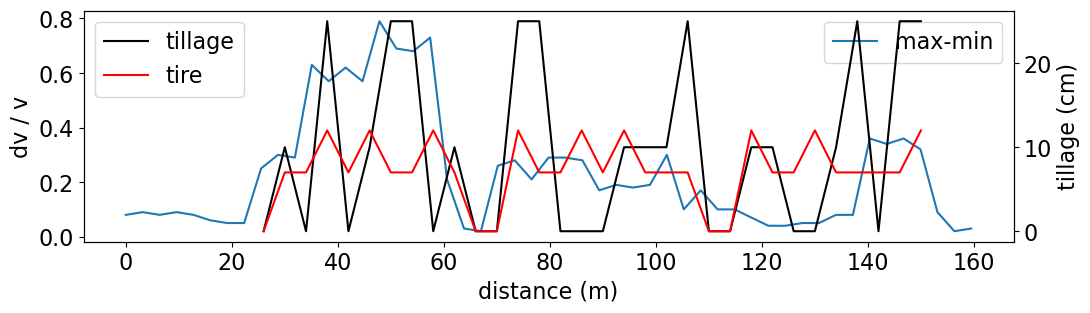

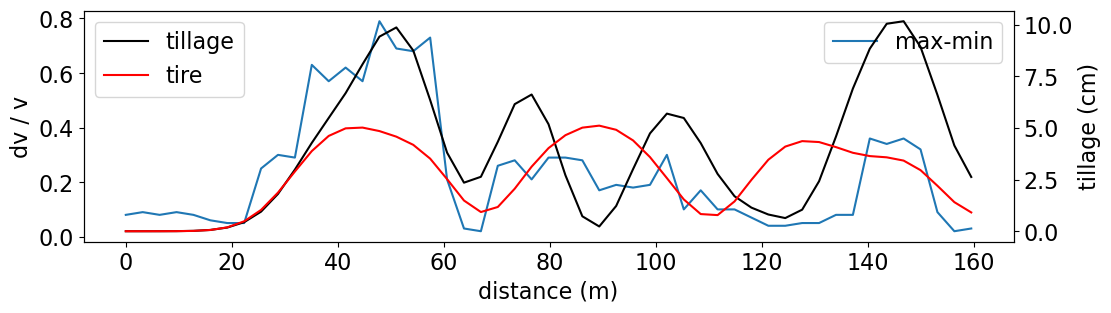

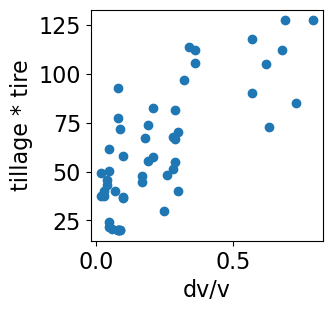

In [5]:
winlen = 5
#### Use two-plot width as the spare the width
tillage = np.array([0, 10, 0, 25, 0, 10, 25, 25, 0, 10,    0,0,     25, 25, 0, 0, 0, 10, 10, 10, 25,   0,0,    10, 10, 0, 0, 10, 25, 0, 25, 25])
tire = np.array([0, 7, 7, 12, 7, 12, 7, 7, 12, 7,   0,0,   12, 7, 7, 12, 7, 12, 7, 7, 7,    0,0,     12, 7, 7, 12, 7, 7, 7, 7, 12])
randomness = np.array([-1, 1, 2, 2, 0, 2, 0, 2, 2, 0, -1,-1, 2, 0, 2, 2, 0, 2, 2, 0, 2, -1,-1, 2, 0, 2, 2, 2, 0, 0, 2, 2])

minamp= np.nanmin(amp[:,160:250], axis=1)
maxamp= np.nanmax(amp[:,160:250], axis=1)
plt.figure(figsize=(12, 3))
# plt.plot(np.arange(51)*dchan, minamp, label='min')
plt.plot(np.arange(51)*dchan, maxamp-minamp, label='max-min')
plt.xlabel("distance (m)", fontsize = 16)
plt.ylabel("dv / v", fontsize = 16)
plt.legend()

axcopy = plt.twinx()
axcopy.plot(np.arange(32)*4+26, tillage, color='k', label='tillage')
axcopy.plot(np.arange(32)*4+26, tire, color='r', label='tire')
axcopy.set_ylabel("tillage (cm)", fontsize = 16)
axcopy.legend()

#### Interpolate tillage and tire pressure
f = interp1d(np.arange(32)*4+26, tillage, bounds_error=False, fill_value=5)
intep_tillage = f(np.arange(51)*dchan)
conv_tillage = np.convolve(intep_tillage, np.ones(winlen)/winlen, mode='same')
f = interp1d(np.arange(32)*4+26, tire, bounds_error=False, fill_value=4)
intep_tire = f(np.arange(51)*dchan)
conv_tire = np.convolve(intep_tire, np.ones(winlen)/winlen, mode='same')

conv_dvv = np.convolve(maxamp-minamp, np.ones(1)/1, mode='same')

conv_tillage = gaussian_filter1d(intep_tillage, sigma=2, mode='reflect')
conv_tire = gaussian_filter1d(intep_tire, sigma=2, mode='reflect')

plt.figure(figsize=(12, 3))
# plt.plot(np.arange(51)*dchan, minamp, label='min')
plt.plot(np.arange(51)*dchan, conv_dvv, label='max-min')
plt.xlabel("distance (m)", fontsize = 16)
plt.ylabel("dv / v", fontsize = 16)
plt.legend()

axcopy = plt.twinx()
axcopy.plot(np.arange(51)*dchan, conv_tillage-5, color='k', label='tillage')
axcopy.plot(np.arange(51)*dchan, conv_tire-4, color='r', label='tire')
axcopy.set_ylabel("tillage (cm)", fontsize = 16)
axcopy.legend()


#### covariance
plt.figure(figsize=(3, 3))
plt.plot(conv_dvv,conv_tillage*conv_tire,'o')
plt.xlabel("dv/v", fontsize = 16)
plt.ylabel("tillage * tire", fontsize = 16)

Text(0, 0.5, 'tillage * tire')

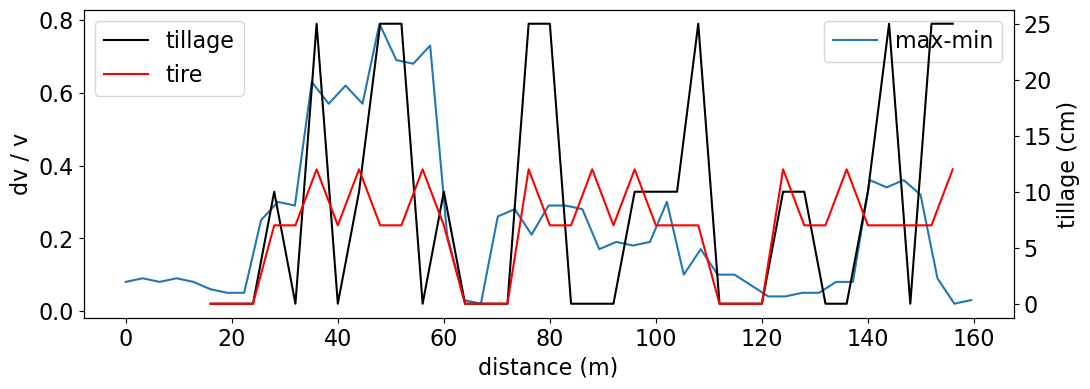

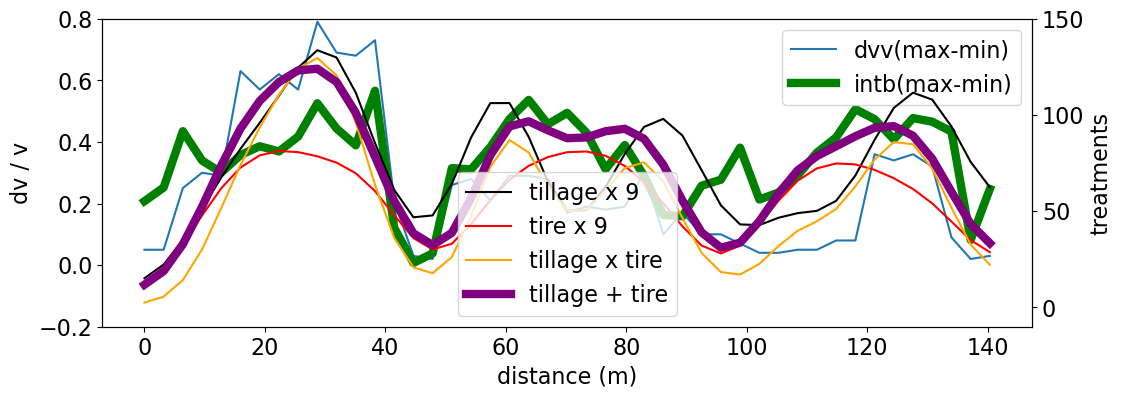

In [6]:
winlen = 5
convmode = 'same'
#### Use three-plot width as the spare the width
tillage = np.array([0,0,0,   10, 0, 25, 0, 10, 25, 25, 0, 10,    0,0,0,    25, 25, 0, 0, 0, 10, 10, 10, 25,    0,0,0,   10, 10, 0, 0, 10, 25, 0, 25, 25])
tire = np.array([0,0,0,  7, 7, 12, 7, 12, 7, 7, 12, 7,    0,0,0,     12, 7, 7, 12, 7, 12, 7, 7, 7,    0,0,0,    12, 7, 7, 12, 7, 7, 7, 7, 12])
randomness = np.array([-1,-1,-1, 1, 2, 2, 0, 2, 0, 2, 2, 0, -1,-1,-1, 2, 0, 2, 2, 0, 2, 2, 0, 2, -1,-1,-1, 2, 0, 2, 2, 2, 0, 0, 2, 2])

plt.figure(figsize=(12, 4))
# plt.plot(np.arange(51)*dchan, minamp, label='min')
plt.plot(np.arange(51)*dchan, maxamp-minamp, label='max-min')
plt.xlabel("distance (m)", fontsize = 16)
plt.ylabel("dv / v", fontsize = 16)
plt.legend()

axcopy = plt.twinx()
axcopy.set_ylabel("tillage (cm)", fontsize = 16)
axcopy.plot(np.arange(36)*4+16, tillage, color='k', label='tillage')
axcopy.plot(np.arange(36)*4+16, tire, color='r', label='tire')
axcopy.legend()

#### Interpolate tillage and tire pressure
f = interp1d(np.arange(36)*4-3, tillage, bounds_error=False, fill_value=1)
intep_tillage = f(np.arange(51-6)*dchan)
conv_tillage = np.convolve(intep_tillage, np.ones(winlen)/winlen, mode=convmode)
f = interp1d(np.arange(36)*4-3, tire, bounds_error=False, fill_value=1)
intep_tire = f(np.arange(51-6)*dchan)
conv_tire = np.convolve(intep_tire, np.ones(winlen)/winlen, mode=convmode)

conv_dvv = np.convolve(maxamp-minamp, np.ones(1)/1, mode=convmode)
# conv_intb= np.convolve(maxb-minb, np.ones(3)/3, mode=convmode)

conv_tillage = gaussian_filter1d(intep_tillage, sigma=2, mode='reflect')
conv_tire = gaussian_filter1d(intep_tire, sigma=2, mode='reflect')
# conv_dvv = gaussian_filter1d(maxamp-minamp, sigma=1, mode='reflect')
conv_intb = gaussian_filter1d(maxb-minb, sigma=0.5, mode='reflect')



plt.figure(figsize=(12, 4))
# plt.plot(np.arange(51)*dchan, minamp, label='min')
plt.plot(np.arange(len(conv_dvv[6:]))*dchan, conv_dvv[6:], label='dvv(max-min)')
plt.plot(np.arange(len(conv_intb[6:]))*dchan, conv_intb[6:]/80, label='intb(max-min)', color='g', lw=6)
plt.xlabel("distance (m)", fontsize = 16)
plt.ylabel("dv / v", fontsize = 16)
plt.legend()
plt.ylim(-0.2, 0.8)

axcopy = plt.twinx()
axcopy.plot(np.arange(len(conv_tillage))*dchan, conv_tillage*9, color='k', label='tillage x 9')
axcopy.plot(np.arange(len(conv_tire))*dchan, conv_tire*9, color='r', label='tire x 9')
axcopy.plot(np.arange(len(conv_tire))*dchan, conv_tillage*conv_tire, color='orange', label='tillage x tire')
axcopy.plot(np.arange(len(conv_tire))*dchan, (conv_tire*15+conv_tillage*conv_tire)/2.1, color='purple', label='tillage + tire', lw=6)
axcopy.set_ylabel("treatments", fontsize = 16)
axcopy.legend()
axcopy.set_ylim(-10, 150)


#### covariance
plt.figure(figsize=(3, 3))
plt.plot(conv_dvv[6:],conv_tillage*conv_tire,'o')
plt.xlabel("dv/v", fontsize = 16)
plt.ylabel("tillage * tire", fontsize = 16)


In [16]:
interp_paras = pd.DataFrame(data={'dvv_varibility': conv_dvv[6:],
                                'intb_varibility': conv_intb[6:],
                                'tillage_depth': conv_tillage, 
                                'tire_pressure': conv_tire})

interp_paras.to_csv('/fd1/QibinShi_data/England_farm/interp_dv_b_tillage_tire.csv')

In [24]:
with h5py.File('/fd1/QibinShi_data/England_farm/enhanced_dvv_cc.hdf5', 'w') as f:
    f.create_dataset("dvv_enhanced", data=amp)
    f.create_dataset("cc", data=cc_dvv)

### Save

In [ ]:
# with h5py.File('/fd1/QibinShi_data/England_farm/all_dvv_denoised.hdf5', 'w') as f:
#     f.create_dataset("dvv_denoised", data=new_dvv)
#     f.create_dataset("cc_denoised", data=new_cc)

### Interpolate soil measurements

In [25]:
interpx = np.arange(ave_psd.shape[0])

interp_f = interp1d(hourly_index, humidity, bounds_error=False, fill_value="extrapolate")
interp_humidity = interp_f(interpx)

interp_f = interp1d(hourly_index, soil_temp_10, bounds_error=False, fill_value="extrapolate")
interp_temp10 = interp_f(interpx)

interp_f = interp1d(np.arange(0,ave_psd.shape[0],5), new_peaks, axis=-1, bounds_error=False, fill_value="extrapolate")
interp_dvv = interp_f(interpx)

interp_f = interp1d(np.arange(0,ave_psd.shape[0],5), cc_dvv, axis=-1, bounds_error=False, fill_value="extrapolate")
interp_cc = interp_f(interpx)

In [26]:
xax=np.arange(0, ave_psd.shape[-1], 240)
tax=acqu_time[:ave_psd.shape[-1]:240]
hrax=[dt.strftime('%d %H:%M') for dt in tax]

(-0.02, 0.2)

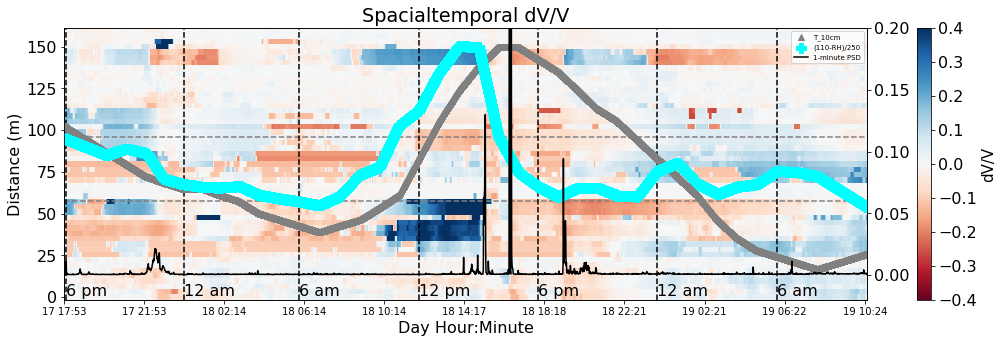

In [27]:
plt.figure(figsize=(18, 5))

plt.pcolormesh(interpx, np.arange(51)*dchan, interp_dvv-np.mean(interp_dvv, axis=1, keepdims=True), shading='auto', vmin=-0.4, vmax=0.4, cmap = 'RdBu')
plt.title('Spacialtemporal dV/V')
plt.xticks(xax, hrax, fontsize = 10)
bar=plt.colorbar()
bar.set_label('dV/V', fontsize = 15)
plt.xlabel("Day Hour:Minute", fontsize = 16)
plt.ylabel("Distance (m)", fontsize = 16)

plt.axhline(y = 18*dchan, color = 'gray', linestyle='--')
plt.axhline(y = 30*dchan, color = 'gray', linestyle='--')
for it in Ind6hrs:
    plt.axvline(x = it, color = 'k', linestyle='--')
plt.text(Ind6hrs[0], 0.5, '6 pm', color='k')
plt.text(Ind6hrs[1], 0.5, '12 am', color='k')
plt.text(Ind6hrs[2], 0.5, '6 am', color='k')
plt.text(Ind6hrs[3], 0.5, '12 pm', color='k')
plt.text(Ind6hrs[4], 0.5, '6 pm', color='k')
plt.text(Ind6hrs[5], 0.5, '12 am', color='k')
plt.text(Ind6hrs[6], 0.5, '6 am', color='k')

axcopy = plt.twinx()
axcopy.scatter(interpx, (interp_temp10-7.5)/20, label='T_10cm', color='gray', marker='^')
axcopy.scatter(interpx, (110-interp_humidity)/250, label='(110-RH)/250', color='cyan', marker='P', s=100)
axcopy.plot(interpx, ave_psd, label='1-minute PSD', color='k')
axcopy.legend(fontsize = 7)
axcopy.set_ylim(-0.02,0.2)

In [208]:
with h5py.File('/fd1/QibinShi_data/England_farm/interp_dvv_temp_moisture.hdf5', 'w') as f:
    f.create_dataset("dvv", data=interp_dvv)
    f.create_dataset("cc", data=interp_cc)
    f.create_dataset("temperature", data=interp_temp10)
    f.create_dataset("moisture", data=interp_humidity)
    f.create_dataset("psd_rain", data=ave_psd)